## Import packages and data

https://github.com/calbal91/project-understanding-elections \
Some of the code is adapted and taken from the above GitHub Respository

In [1]:
#For data manipulation
import numpy as np
import pandas as pd
import json
import math

#For data visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.lines import Line2D
import matplotlib.font_manager
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from matplotlib.pylab import rcParams

#For data pre-processing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

#For clustering analysis
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

#For evaluating clusters
from sklearn.metrics import calinski_harabasz_score
from scipy.cluster.hierarchy import dendrogram, ward

#Suppress warnings from showing
import warnings
warnings.filterwarnings('ignore')

#Allow ourselves to save things
import pickle

In [2]:
df_con = pd.read_csv('data_with_targets.csv')

In [3]:
df_con.head()

,ID,Constituency,Region,Type,Population,0-9,10-19,20-29,30-39,40-49,...,Depression,Obesity,Diabetes,Asthma,DiseasesPerPop,%LeaveVote,%17Turnout,Winner_17,seat_types_17,seat_types_yg
0,E14000554,Berwick-upon-Tweed,North East,Rural,75425,0.0863,0.0863,0.0902,0.1002,0.1102,...,0.08551,0.13193,0.08029,0.07315,0.89389,0.553,0.719149,Con,con safe,con safe
1,E14000569,Bishop Auckland,North East,Rural,89415,0.1063,0.1086,0.1103,0.1090,0.1206,...,0.12388,0.14646,0.08225,0.06856,0.89166,0.609,0.640827,Lab,con lab marginal,con lab marginal
2,E14000574,Blaydon,North East,Small Town,87978,0.1053,0.1050,0.0984,0.1225,0.1284,...,0.09790,0.12590,0.07011,0.06651,0.82772,0.561,0.703311,Lab,lab safe,lab safe
3,E14000575,Blyth Valley,North East,Small Town,84340,0.1106,0.1092,0.1087,0.1222,0.1256,...,0.12216,0.13512,0.08322,0.07157,0.88176,0.605,0.671135,Lab,lab safe,con lab marginal
4,E14000641,City of Durham,North East,Small Town,102534,0.0917,0.1195,0.2110,0.1145,0.1068,...,0.09814,0.08893,0.05807,0.05606,0.65024,0.433,0.680566,Lab,lab safe,con lab marginal


In [9]:
df = pd.read_csv('data_with_targets.csv')

## Define functions and colour mappings 

In [10]:
#Define colours for the visuals
CB91_Blue = '#2CBDFE'
CB91_Green = '#47DBCD'
CB91_Pink = '#F3A0F2'
CB91_Purple = '#9D2EC5'
CB91_Violet = '#661D98'
CB91_Amber = '#F5B14C'

CB91_BlueD = '#016794'
CB91_GreenD = '#187970'
CB91_PinkD = '#B317B1'
CB91_PurpleD = '#4E1762'
CB91_VioletD = '#330E4C'
CB91_AmberD = '#985E09'

CB91_BlueL = '#ABE5FF'
CB91_GreenL = '#B5F1EB'
CB91_PinkL = '#FAD9FA'
CB91_PurpleL = '#D9A8EB'
CB91_VioletL = '#ECD4F5'
CB91_AmberL = '#F9D094'


#The following gradients will be used for heatmaps, etc
CB91_Grad_BP = ['#2CBDFE', '#2fb9fc', '#33b4fa', '#36b0f8',
                '#3aacf6', '#3da8f4', '#41a3f2', '#449ff0',
                '#489bee', '#4b97ec', '#4f92ea', '#528ee8',
                '#568ae6', '#5986e4', '#5c81e2', '#607de0',
                '#6379de', '#6775dc', '#6a70da', '#6e6cd8',
                '#7168d7', '#7564d5', '#785fd3', '#7c5bd1',
                '#7f57cf', '#8353cd', '#864ecb', '#894ac9',
                '#8d46c7', '#9042c5', '#943dc3', '#9739c1',
                '#9b35bf', '#9e31bd', '#a22cbb', '#a528b9',
                '#a924b7', '#ac20b5', '#b01bb3', '#b317b1']

CB91_Grad_BA = ['#2cbdfe', '#31bdf9', '#36bcf5', '#3bbcf0',
                '#41bcec', '#46bbe7', '#4bbbe3', '#50bbde',
                '#55bbd9', '#5abad5', '#60bad0', '#65bacc',
                '#6ab9c7', '#6fb9c3', '#74b9be', '#79b8ba',
                '#7eb8b5', '#84b8b0', '#89b7ac', '#8eb7a7',
                '#93b7a3', '#98b79e', '#9db69a', '#a3b695',
                '#a8b690', '#adb58c', '#b2b587', '#b7b583',
                '#bcb47e', '#c1b47a', '#c7b475', '#ccb371',
                '#d1b36c', '#d6b367', '#dbb363', '#e0b25e',
                '#e6b25a', '#ebb255', '#f0b151', '#f5b14c']

CB91_Grad_AP = ['#f5b14c', '#f3ae4f', '#f0aa52', '#eea755',
                '#eca458', '#eaa05c', '#e79d5f', '#e59962',
                '#e39665', '#e19368', '#de8f6b', '#dc8c6e',
                '#da8971', '#d88574', '#d58277', '#d37f7b',
                '#d17b7e', '#cf7881', '#cc7584', '#ca7187',
                '#c86e8a', '#c66a8d', '#c36790', '#c16493',
                '#bf6096', '#bd5d9a', '#ba5a9d', '#b856a0',
                '#b653a3', '#b450a6', '#b14ca9', '#af49ac',
                '#ad46af', '#ab42b2', '#a83fb5', '#a63bb9',
                '#a438bc', '#a235bf', '#9f31c2', '#9d2ec5']

CB91_Grad_GP = ['#47dbcd', '#4bd9ce', '#50d8cf', '#54d6d0',
                '#59d5d1', '#5dd3d2', '#61d2d3', '#66d0d4',
                '#6acfd5', '#6fcdd6', '#73ccd6', '#78cad7',
                '#7cc9d8', '#80c7d9', '#85c6da', '#89c4db',
                '#8ec3dc', '#92c1dd', '#96c0de', '#9bbedf',
                '#9fbde0', '#a4bbe1', '#a8bae2', '#acb8e3',
                '#b1b7e4', '#b5b5e5', '#bab4e6', '#beb2e7',
                '#c2b1e8', '#c7afe9', '#cbaee9', '#d0acea',
                '#d4abeb', '#d9a9ec', '#dda8ed', '#e1a6ee',
                '#e6a5ef', '#eaa3f0', '#efa2f1', '#f3a0f2']

CB91_Grad_GWP= ['#47dbcd','#4fdcce','#56ddd0','#5dded1',
                '#64dfd2','#6ae0d3','#70e1d5','#75e2d6',
                '#7be3d7','#80e4d8','#85e5da','#8ae6db',
                '#8fe7dc','#94e8dd','#98e9df','#9deae0',
                '#a1ebe1','#a6ece2','#aaede4','#afede5',
                '#b3eee6','#b7efe8','#bbf0e9','#c0f1ea',
                '#c4f2eb','#c8f3ed','#ccf4ee','#d0f5ef',
                '#d4f6f1','#d8f6f2','#dcf7f3','#e0f8f5',
                '#e4f9f6','#e8faf7','#ecfbf8','#f0fcfa',
                '#f3fcfb','#f7fdfc','#fbfefe','#ffffff',
                '#fdfafe','#fbf5fc','#f9f0fb','#f7eaf9',
                '#f4e5f8','#f2e0f7','#f0dbf5','#eed6f4',
                '#ecd1f2','#e9ccf1','#e7c7f0','#e5c1ee',
                '#e2bced','#e0b7eb','#deb2ea','#dbade8',
                '#d9a8e7','#d6a3e5','#d49ee4','#d199e2',
                '#cf94e1','#cc8fdf','#ca89de','#c784dc',
                '#c57fdb','#c27ad9','#bf75d8','#bd6fd6',
                '#ba6ad5','#b765d3','#b45fd2','#b25ad0',
                '#af54cf','#ac4ecd','#a949cb','#a642ca',
                '#a33cc8','#a035c7','#9d2ec5']

CB91_Grad_BWP= ['#2cbdfe','#31bffe','#37c0fe','#3cc2fe',
                '#42c4fe','#47c5fe','#4cc7fe','#52c9fe',
                '#57cbfe','#5dccfe','#62cefe','#68d0fe',
                '#6dd1fe','#72d3fe','#78d5fe','#7dd6fe',
                '#83d8fe','#88dafe','#8ddbfe','#93ddfe',
                '#98dfff','#9ee1ff','#a3e2ff','#a8e4ff',
                '#aee6ff','#b3e7ff','#b9e9ff','#beebff',
                '#c3ecff','#c9eeff','#cef0ff','#d4f1ff',
                '#d9f3ff','#dff5ff','#e4f7ff','#e9f8ff',
                '#effaff','#f4fcff','#fafdff','#ffffff',
                '#fdfafe','#fbf5fc','#f9f0fb','#f7eaf9',
                '#f4e5f8','#f2e0f7','#f0dbf5','#eed6f4',
                '#ecd1f2','#e9ccf1','#e7c7f0','#e5c1ee',
                '#e2bced','#e0b7eb','#deb2ea','#dbade8',
                '#d9a8e7','#d6a3e5','#d49ee4','#d199e2',
                '#cf94e1','#cc8fdf','#ca89de','#c784dc',
                '#c57fdb','#c27ad9','#bf75d8','#bd6fd6',
                '#ba6ad5','#b765d3','#b45fd2','#b25ad0',
                '#af54cf','#ac4ecd','#a949cb','#a642ca',
                '#a33cc8','#a035c7','#9d2ec5']

#Add party colors
con_blue = '#0A3B7C'
lab_red = '#E4003B'
lib_yel = '#FAA61A'
snp_yel = '#FFF481'
green_green = '#52DF00'
brex_blue = '#00E2ED'
ukip_pur = '#470A65'
plaid_green = '#006A56'

con_lab = '#992281'
con_lib = '#837859'
con_snp = '#85987f'
lab_lib = '#ef532b'
lab_snp = '#f27a5e'
lib_snp = '#fccf4d'


#A list that we'll use to cycle through colors in charts
color_list = [CB91_Blue, CB91_Green, CB91_Amber, CB91_Pink,
              CB91_Violet, CB91_BlueD, CB91_GreenD, CB91_Purple,
              CB91_AmberL, CB91_BlueL, CB91_GreenL, CB91_AmberD, 
              CB91_VioletD, CB91_PinkL, CB91_VioletL, CB91_PinkD]







def cluster_IDs(cluster, cluster_data, cluster_col='Cluster'):
    
    '''
    Takes a cluster label (1, 2, 3, etc.) and a cluster dataframe,
    and returns a list of constituency IDs that belong to the given cluster
    '''
    return list(cluster_data.loc[cluster_data['Cluster']==cluster].index)



def cluster_kpi(kpi, data, cluster_data, cluster_col='Cluster'):
    
    '''
    For a given set of cluster labels, and a given KPI, returns a
    dataframe with one row, for that given kpi
    '''
    
    #Find the unique cluster labels
    cluster_labels = sorted(list(cluster_data[cluster_col].unique()))
    
    #Declare an empty list to store the KPI data in
    kpi_values = []
    
    #Iterate through the labels
    for i in cluster_labels:
        #Work out which constituencies are in the cluster
        cluster_index = cluster_IDs(cluster = i,
                                    cluster_data = cluster_data,
                                    cluster_col = cluster_col)
        
        #Go to the data table, and find the mean for that kpi
        #for those constituencies. Append to the list
        mean = data.loc[cluster_index, kpi].mean()
        kpi_values.append(mean)
        
    #Create and return a dataframe as required
    return pd.DataFrame([kpi_values],
                        columns = cluster_labels,
                        index = [kpi])



def cluster_kpis(kpis, data, cluster_data, cluster_col='Cluster'):
    
    '''
    For a list of KPIs, return a dataframe showing mean
    values on a cluster by cluster basis
    
    '''
    
    #Declare an empty dataframe
    df_temp = pd.DataFrame()
    
    #For each kpi, find the average cluster means, and append to the dataframe
    for i in kpis:
        cluster_values = cluster_kpi(kpi=i,
                                     data=data,
                                     cluster_data=cluster_data,
                                     cluster_col=cluster_col)
        
        df_temp = pd.concat([df_temp, cluster_values])
        
    return df_temp
        
        

def heatmap_cluster_kpis(kpis, data,
                       cluster_data,
                       size=0.4,
                       cmap=CB91_Grad_BP,
                       cluster_col='Cluster'):
    
    '''
    Heatmap the table produced by the cluster_kpis function
    '''
    
    #Calculate the required table and transpose
    df_temp = cluster_kpis(kpis=kpis,
                           data=data,
                           cluster_data=cluster_data,
                           cluster_col=cluster_col).T
    
    #For each kpi, scale as required
    scaler = MinMaxScaler()
    scaler.fit(df_temp)
    df_scale = scaler.transform(df_temp)
    
    df_scale = pd.DataFrame(df_scale,
                            columns=df_temp.columns,
                            index=df_temp.index)
    
    height = size*len(df_scale.index)
    width = 1.1*size*len(df_scale.columns)
    
    plt.figure(figsize=(width,height))
    sns.heatmap(df_scale,cbar=True,cmap=cmap)
    plt.yticks(rotation='horizontal')


#Use seaborn to set all the default chart visual settings
sns.set(font='Franklin Gothic Book',
        rc={
 'axes.axisbelow': False,
 'axes.edgecolor': 'lightgrey',
 'axes.facecolor': 'white',
 'axes.grid': False,
 'axes.labelcolor': 'dimgrey',
 'axes.spines.right': False,
 'axes.spines.top': False,
 'figure.facecolor': 'white',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'text.color': 'dimgrey',
 'xtick.bottom': False,
 'xtick.color': 'dimgrey',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': 'dimgrey',
 'ytick.direction': 'out',
 'ytick.left': False,
 'ytick.right': False})

sns.set_context("notebook", rc={"font.size":16,
                                "axes.titlesize":20,
                                "axes.labelsize":16})

plt.rcParams['axes.prop_cycle'] = plt.cycler(color=color_list)

In [11]:
def gradient_mapper(kpi, grad, outliers=None, stretch=1, factor=1):
    
    '''
    Takes a list/series of numbers, outputs a list of hex colours,
    appropriate for heatmapping the initial data.
    
    Parameters:
    - col (list/series, etc.): The data to be transformed
    - grad (list hex codes): A list of colors that the data will be transformed to
    - outliers (top,bottom,both): Stretches the outliers, resulting in more gradient
                                  change amongst clustered values
    - stretch (int): The number of colors to duplicate if outliers variable used
    - factor (int): The scale of color duplication if outliers variable used
    
    '''
    #Work out how many colours we have in the given gradient
    colors = len(grad)
    half = colors // 2
    
    #Ensure that stretch is possible
    stretch = min(half//3, stretch)
    
    factors = [4*factor, 3*factor, 2*factor]
    
    if outliers != None:
        #Stretch gradient if required. Declare three lists:
        #Start is the stretch map for the bottom end
        if (outliers.lower() == 'bottom') or (outliers.lower() == 'both'):
            start = [factors[0]]*stretch + [factors[1]]*stretch + [factors[2]]*stretch
        else:
            start = []

        #End is the stretch map for the top end
        if (outliers.lower() == 'top') or (outliers.lower() == 'both'):
            end = [factors[2]]*stretch + [factors[1]]*stretch + [factors[0]]*stretch
        else:
            end = []

        #Middle is a list of 1s which will be non-transformed
        middle = [1 for i in range(colors - len(start) - len(end))]

        stretch_map = start + middle + end
        
    else:
        stretch_map = [1 for i in range(colors)]
        
    #Create tuples of the gradients, and the number of
    #times they should be repeated in the list
    zip_list = list(zip(grad,stretch_map))
    
    #Use this to create a list of lists
    #Each element will be a list of the same gradient
    #repeated the required number of times
    list_of_lists = [[i[0]]*i[1] for i in zip_list]
    
    #Melt this list of lists into a single list
    grad = sum(list_of_lists, [])
    
    #Re-define colors variable
    colors = len(grad)-1
    
    #Define the lowest and the highest points in the dataset
    kpi_min = kpi.min()
    kpi_max = kpi.max()
    
    #Transform the data to integers between zero and the length of the gradient list
    first_map = list(map(lambda x: int(round(colors*(x-kpi_min) /
                                             (kpi_max-kpi_min),0)), list(kpi)))
    
    #Map the integers onto the gradient list
    second_map = list(map(lambda x: grad[x], first_map))
    
    #Return this, as well as the new gradient
    return second_map, grad




f = open('constituencieshex.json')
datamap = json.load(f)
datamap = pd.DataFrame(datamap['hexes']).T
datamap = datamap[['n','q','r']]
datamap.columns=['Name','X','Y']

def kpi_map(kpi, width=6, colorbar=True,
            outliers=None, stretch=1, factor=1,
            exclude=[], title=None,
            colors=None, exc_color='#999999',
            grad=CB91_Grad_AP, data=df):
    
    '''
    Outputs a choropleth map, showing each constituency in the same size.
    
    Parameters:
    - kpi (list/series, etc.): The data to be transformed
    - width (float): The desired width of the figure
    - df (dataframe): The dataframe to get the data from
    - grad (list hex codes): A list of colors that the data will be transformed to
    - outliers (top,bottom,both): Stretches the outliers, resulting in more gradient
                                  change amongst clustered values
    - stretch (int): The number of colors to duplicate if outliers variable used
    - factor (int): The scale of color duplication if outliers variable used
    - exclude (list): A list of regions to exclude from the chart
    - colors (dataframe): A dataframe of hex-codes (index should be constituency codes)
    - title (string): The desired title of the chart
    
    '''    
    
    #Filter out different regions, depending on paramaters
    df_filtered = pd.concat([datamap, data[['Region',kpi]]], axis=1)
    
    #If we have colors to add, concatonate these in
    if isinstance(colors, pd.DataFrame):
        df_filtered = pd.concat([df_filtered, colors], axis=1)
        df_filtered.columns = ['Name', 'X', 'Y', 'Region', kpi, 'Colors']
    
    df_filtered = df_filtered.loc[~df_filtered['Region'].isin(exclude)]
    kpi_filtered = df_filtered[kpi]
    
    if isinstance(colors, pd.DataFrame) is False:
        #Use the gradient mapper function to return the colors for the plot
        gradient_map = gradient_mapper(kpi=kpi_filtered,
                                    grad=grad,
                                    outliers=outliers,
                                    stretch=stretch,
                                    factor=factor)
        colors_map = gradient_map[0]
    
    else:
        #Fill in nan colors with white
        df_filtered['Colors'].fillna(exc_color, inplace=True)
        
        #Return the column to be used as the colours list in the plot
        colors_map = list(df_filtered['Colors'])
    
    #Work out the aspect ratio of the filtered constituencies
    X_diff = np.max(df_filtered['X'])-np.min(df_filtered['X'])
    Y_diff = np.max(df_filtered['Y'])-np.min(df_filtered['Y'])
    
    #Declare the width and height of the plot
    height = width * (Y_diff/X_diff)
    size = 500*math.pi*((width/X_diff)**2)
    
    #Create the figure
    fig, ax = plt.subplots(figsize=(width,height))
    
    plt.xticks([])
    plt.yticks([])

    #Plot the scatter
    ax1 = fig.add_subplot(1,1,1)
    ax1.scatter(df_filtered['X'],
                df_filtered['Y'],
                s=size,
                marker='s',
                c=colors_map)
    
    #Remove axes
    sns.despine(left=True, bottom=True)
    ax1.set_title(title);
    
    #plot the colorbar
    if (colorbar == True) and isinstance(colors, pd.DataFrame) is False:        
        cmap = LinearSegmentedColormap.from_list(name= '',
                                                 colors=gradient_map[1])
        ax2 = fig.add_subplot(2,30,28)
        norm = mpl.colors_map.Normalize(vmin=df_filtered[kpi].min(),
                                    vmax=df_filtered[kpi].max())
        cb = mpl.colorbar.ColorbarBase(ax2, cmap=cmap,
                                       norm=norm, orientation='vertical')
    
        # remove the x and y ticks
        for ax in [ax1,ax2]:
            ax.set_xticks([])
            ax.set_yticks([])
    
    else:
        ax1.set_xticks([])
        ax1.set_yticks([])

In [12]:
df.head(2)

,ID,Constituency,Region,Type,Population,0-9,10-19,20-29,30-39,40-49,...,Depression,Obesity,Diabetes,Asthma,DiseasesPerPop,%LeaveVote,%17Turnout,Winner_17,seat_types_17,seat_types_yg
0,E14000554,Berwick-upon-Tweed,North East,Rural,75425,0.0863,0.0863,0.0902,0.1002,0.1102,...,0.08551,0.13193,0.08029,0.07315,0.89389,0.553,0.719149,Con,con safe,con safe
1,E14000569,Bishop Auckland,North East,Rural,89415,0.1063,0.1086,0.1103,0.1090,0.1206,...,0.12388,0.14646,0.08225,0.06856,0.89166,0.609,0.640827,Lab,con lab marginal,con lab marginal


## Data preprocessing and Feature engineering 

In [13]:
df.set_index('ID', inplace=True)


# We first remove the Northern Ireland Region and Chorley seat (Speaker Seat) since these will cause outliers
df = df.loc[(df['Region'] != 'Northern Ireland')
           &(df['Constituency'] != 'Chorley')]

# Copy the data so you can use later if needed
data = df.copy()

# Remove constituency, type, and region column as we do not any geographic location data to affect our clustering
df = df.iloc[:, 4:]

# Reduce the ranges of the age columns
# Looking at all the age columns, it is best to combine some of them say above 60 category as the more older a person gets, 
# it maybe that he does not even vote or separating ages into such narrow categories does not seem to produce much benefit. 
# So our proposed categories would be (0-19) (how many kids/teenagers a household has, going uni etc), (20-29) 
# would involve uni,
# marriage, work life etc, (30-59) would include mainly parents, adulthood, maturity, richer category compared 
# to other categories, 60-80+ would represent old age categories.
# df['0-19%'] = df.iloc[:, 1] + df.iloc[:, 2]
df['0-9'] = df.iloc[:, 1] + df.iloc[:, 2]
df.rename(columns={'0-9': '0-19%'}, inplace=True)
df.drop(columns=['10-19'], inplace=True)

df['30-39'] = df['30-39'] + df['40-49'] + df['50-59']
df.rename(columns={'30-39': '30-59%'}, inplace=True)
df.rename(columns={'20-29': '20-29%'}, inplace=True)

df.drop(columns=['40-49', '50-59'], inplace=True)
df['60-69'] = df['60-69'] + df['70-79'] + df['80+']
df.rename(columns={'60-69': '60+%'}, inplace=True)
df.drop(columns=['70-79', '80+'], inplace=True)

# We will restrict born regions to 'Born UK', 'Born Asia', 'Born Other Europe', 'Born Rest of the World' which can 
# signficantly better focus target campaigns of different political parties as to target even more than 3 ethnicities
# does require lot of effort.

# With regards to religion, we can use the top 3-4 categories of religion according to wikipedia which would be Christianity, 
# Islam, No religion or atheism and Hinduisim. There are 7 categories in the current dataframe and targeting all these religions
# specifically would not be very effective. We will restrict to 4 categories specifically: Islam, Christianity, No religion and 
# other religion

# Born UK and being Christian is highly correlated or being white and christian or being south asian and muslim. 
# As our focus on predicting clusters rather than interpreting the parameters obtained, having such intercorrelation 
# issues should not be an issue.

# Lastly, concerning race colour, I believe the 4 mentioned (White, Black, Asian, Mixed) are sufficient to be used 
# for our clustering algorithms

# Country of Birth
df['%BornSouthAsia'] = df['%BornSouthAsia'] + df['%BornSEAsia'] + df['%BornEastAsia']
df.rename(columns={'%BornSouthAsia': '%Born_Asia'}, inplace=True)
df.drop(columns=['%BornSEAsia', '%BornEastAsia'], inplace=True)

df['%BornIreland'] = df['%BornIreland'] + df['%BornOtherEU'] + df['%BornOtherEurope']
df.rename(columns={'%BornIreland': '%Born_Other_Europe'}, inplace=True)
df.drop(columns=['%BornOtherEU', '%BornOtherEurope'], inplace=True)


df['%BornAfrica'] = df['%BornAfrica'] + df['%BornME'] + df['%BornNAmerica'] + df['%BornLatinAmerica'] + df['%BornAustralasia']
df.rename(columns={'%BornAfrica': '%Born_RestOf_theWorld'}, inplace=True)
df.drop(columns=['%BornME', '%BornNAmerica', '%BornLatinAmerica', '%BornAustralasia'], inplace=True)


# Religion
df['%Sikh'] = df['%Sikh'] + df['%Hindu'] + df['%Buddhist'] + df['%Jewish']
df.rename(columns={'%Sikh': '%Other_Religion'}, inplace=True)
df.drop(columns=['%Hindu', '%Jewish', '%Buddhist'], inplace=True)


# Obtain only the Great Britian dataset by droppping all columns which have NAs
# When we drop all columns with NAs, we keep rows with constituencies being from Scotland and Wales 
# as these constituencies cause the NAs mainly. 
# When we drop all rows with NAs, automatically these constituencies are removed

df_gb = df.dropna(axis=1)
df_gb.to_csv('data_gb.csv')

In [14]:
df_gb = pd.read_csv('data_gb.csv', index_col='ID')

# Apply log transformations to reduce skewness in the data for dimensionality reduction
df_gb[['AreaKM2', 'Pop_Density','Businesses', 'BusinessesPer1kCap','2019_Wage', 'HousePrice', 
       'HousePricePerWage']].apply(np.log1p, inplace=True)

# GB Dataset
X_gb = df_gb.iloc[:,:-3]
y17_gb = df_gb['Winner_17']
y17_st_gb = df_gb['seat_types_17']
y19_st_gb = df_gb['seat_types_yg'] # You Gov

In [15]:
# Add percentages of seats won by the conservative, labour, liberal, Scottish and Green party in every constituency
df_election = pd.read_csv('HoC-GE2017-constituency-results.csv', index_col='ons_id')
df_election.drop(columns=['ons_region_id', 'constituency_name', 'county_name', 'region_name',
       'country_name', 'constituency_type', 'declaration_time', 'result',
       'first_party', 'second_party', 'electorate'], inplace=True)

df_election.drop(columns=['invalid_votes', 'dup', 'sdlp', 'uup',
       'alliance', 'other', 'other_winner'], inplace=True)

df_election['con%'] = (df_election['con'] / df_election['valid_votes']) * 100
df_election['lab%'] = (df_election['lab'] / df_election['valid_votes']) * 100
df_election['ld%'] = (df_election['ld'] / df_election['valid_votes']) * 100
df_election['snp%'] = (df_election['snp'] / df_election['valid_votes']) * 100
df_election['green%'] = (df_election['green'] / df_election['valid_votes']) * 100
df_election.index.names = ['ID']

# Merge the two datasets together
X_gb = pd.concat([X_gb, df_election[['con%','lab%','ld%','snp%']]], axis=1, join='inner')

In [380]:
X_gb.columns

Index(['0-19%', '20-29%', '30-59%', '60+%', 'AreaKM2', 'Pop_Density',
       'Businesses', '%BusinessGrowth', 'BusinessesPer1kCap', '%Unemployment',
       'UnemploymentChange', '2019_Wage', 'HousePrice', '%HousePriceGrowth',
       'HousePricePerWage', '%OwnOutright', '%OwnWithMort', '%PrivateRent',
       '%SocialHousing', '%Heavy Industry & Manufacturing',
       '%Wholesale & Retail', '%Agriculture', '%Hospitality',
       '%Public Admin & Defence', '%Transport', '%Health & Social Work',
       '%Support & Admin', '%Education', '%Sciences', '%FS & ICT',
       '%Other Industry', '%NoQuals', '%Level1', '%Level2', '%Level3',
       '%Level4+', '%White', '%Mixed', '%Asian', '%Black', '%NoReligion',
       '%Christian', '%Muslim', '%Other_Religion', '%BornUK',
       '%Born_Other_Europe', '%Born_RestOf_theWorld', '%Born_Asia',
       'MbpsSpeed', '%UnableDecent', '%Under10Mbps', '%LeaveVote',
       '%17Turnout', 'con%', 'lab%', 'ld%', 'snp%'],
      dtype='object')

In [381]:
X_gb.shape # No Null Values

(631, 57)

## Standard Scaling

In [18]:
scaler = StandardScaler()
X_gb_scaled = scaler.fit_transform(X_gb)

## Dimensionality Reduction

### PCA

In [158]:
X_gb_scaled.shape

(631, 57)

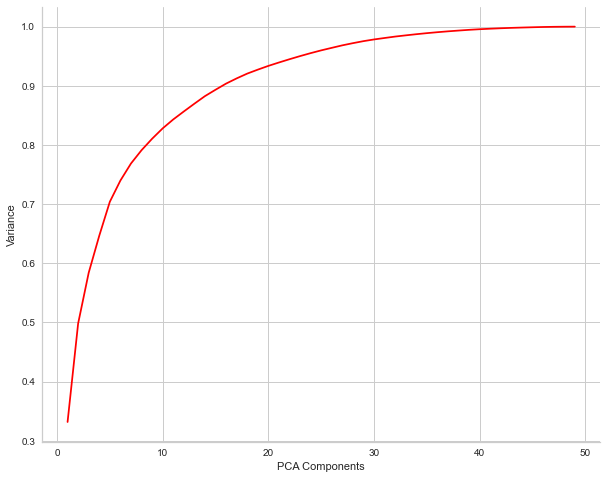

In [159]:
# log columns
from sklearn.decomposition import PCA

pca_list = list()
feature_weight_list = list()

# Fit a range of PCA models

for n in range(1, 50):
    
    # Create and fit the model
    PCAmod = PCA(n_components=n)
    PCAmod.fit(X_gb_scaled) # has 86 features
    
    # Store the model and variance
    pca_list.append(pd.Series({'n':n, 'model':PCAmod,
                               'var': PCAmod.explained_variance_ratio_.sum()}))
    
    
pca_df = pd.concat(pca_list, axis=1).T.set_index('n')


plt.figure(figsize=(10,8))
sns.lineplot(x='n', y='var', data=pca_df, color='red')
plt.xlabel('PCA Components')
plt.ylabel('Variance')
plt.show()

In [160]:
pca_df.sort_values(by='var', ascending=False).head(30)

,model,var
n,,
49,PCA(n_components=49),0.999881
48,PCA(n_components=48),0.999773
47,PCA(n_components=47),0.999587
46,PCA(n_components=46),0.999298
45,PCA(n_components=45),0.998835
44,PCA(n_components=44),0.998347
43,PCA(n_components=43),0.997811
42,PCA(n_components=42),0.997151
41,PCA(n_components=41),0.996377


In [161]:
# Reducing components down to 25 from 58 components still ensures 95% of the variance is explained (-33 features)

In [162]:
PCAmod = PCA(n_components=25)
PCAmod.fit(X_gb_scaled)
PCA_df_gb = pd.DataFrame(PCAmod.transform(X_gb_scaled))

In [299]:
PCA_df_gb.shape

(631, 25)

### UMAP

In [164]:
import umap
umap_c = umap.UMAP(n_components=25, metric='euclidean' , init='random', random_state=0)
umap_df = umap_c.fit_transform(X_gb_scaled)

In [165]:
umap_df.shape

(631, 25)

## Clustering Algorithms

### K-Means

#### UMAP

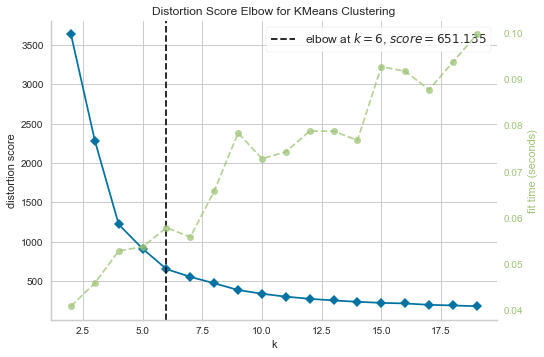

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [544]:
import yellowbrick

# Distortion Score

# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,20), timings= True)
dx = visualizer.fit(umap_df)        # Fit data to visualizer
visualizer.show()        # Finalize and render figure

In [559]:
dx.scoring_metric

<function yellowbrick.cluster.elbow.distortion_score(X, labels, metric='euclidean')>

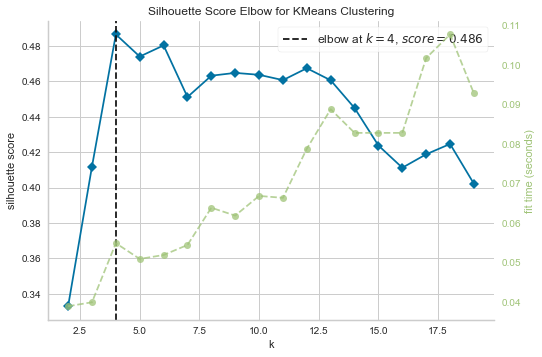

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [167]:
# Silhouette Score

# Silhouette Coefficient is calculated using the mean intracluster distance (d1) and mean nearest cluster distance (d2)
# (d2 - d1) / max(d2 - d1)
# Silhouette Score for K means
# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,20),metric='silhouette', timings= True)
visualizer.fit(umap_df)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

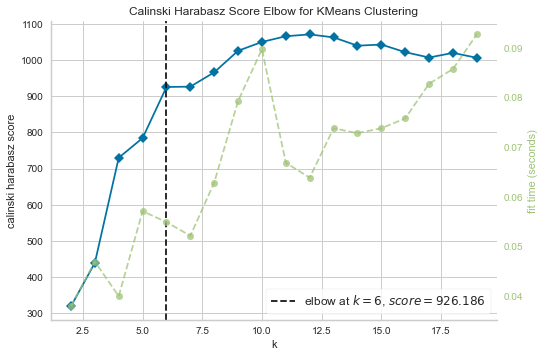

<AxesSubplot:title={'center':'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [168]:
# Calinski Harabasz Score for K means
# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,20),metric='calinski_harabasz', timings= True)
visualizer.fit(umap_df)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

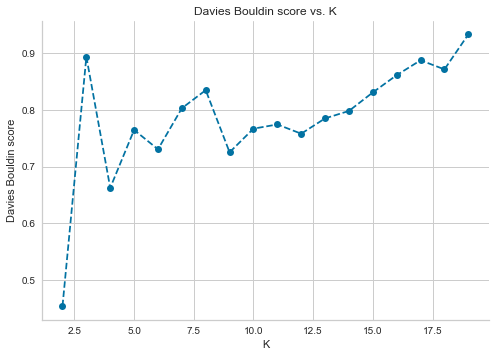

In [169]:
# Davies Bouldin Score
# Davies Bouldin Index - need at least 2 points in each cluster
# As DB Index falls, clustering improves
# Davies Bouldin score for K means
from sklearn.metrics import davies_bouldin_score
def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding Davies Bouldin for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the Davies Bouldin score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters=center)
# Then fit the model to your data using the fit method
    model = kmeans.fit_predict(data)
    
    # Calculate Davies Bouldin score
    score = davies_bouldin_score(data, model)
    
    return score

scores = []
centers = list(range(2,20))
for center in centers:
    scores.append(get_kmeans_score(umap_df, center))


    
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
# plt.vlines(x=6, ymin=0.0, ymax=min(scores), linestyle='--', color='r')
# plt.hlines(y=min(scores), xmin=0, xmax=6, linestyle='--', color='r')
plt.ylabel('Davies Bouldin score');
plt.title('Davies Bouldin score vs. K');
# plt.xlim(1.6, 20)
# plt.ylim(0.7, 1.25)

In [170]:
# 6 Clusters for Davies Bouldin # Gives 2 clusters as recommended
score = pd.DataFrame(scores, columns=['Davies_Bouldin_Score'])
score[score.Davies_Bouldin_Score == score.Davies_Bouldin_Score.min()].index[0]

0

####  Clusters analysis

In [171]:
#Instantiate and run a KMeans algorithm
k_means = KMeans(n_clusters=6)
k_means.fit(umap_df)

#Store the predicted labels
km_preds_gb = []
km_preds_gb.append(k_means.predict(umap_df))

In [172]:
# We will go with 6 clusters

gb_cluster_yg = pd.concat([y19_st_gb,
                           pd.DataFrame(km_preds_gb[0],
                                        index=y17_st_gb.index,
                                        columns=['Cluster'])],
                           axis=1)

gb_cluster_yg_pivot = pd.pivot_table(data = gb_cluster_yg,
                                     index='seat_types_yg',
                                     columns='Cluster',
                                     aggfunc=len,
                                     fill_value=0)

gb_cluster_yg_pivot

Cluster,0,1,2,3,4,5
seat_types_yg,,,,,,
con lab marginal,66,0,21,15,35,10
con ld marginal,0,0,9,4,0,9
con pc marginal,0,0,1,0,0,0
con safe,39,0,114,1,5,100
con snp marginal,0,19,1,0,0,0
green safe,0,0,0,0,1,0
lab ld marginal,0,0,0,0,0,1
lab safe,35,0,1,42,57,0
lab snp marginal,0,10,0,0,0,0


In [173]:
party_list = ['con safe','con lab marginal',
              'lab safe','ld safe',
              'con ld marginal','lab ld marginal',
              'green safe', 'con snp marginal', 'snp safe', 'ld snp marginal']

party_colors = [con_blue, con_lab, lab_red, lib_yel,
               con_lib, lab_lib, green_green, con_snp, snp_yel, lib_snp]

gb_cluster_yg_pivot=gb_cluster_yg_pivot.reindex(party_list)

gb_cluster_bar = (gb_cluster_yg_pivot / gb_cluster_yg_pivot.sum()).T

gb_cluster_bar

seat_types_yg,con safe,con lab marginal,lab safe,ld safe,con ld marginal,lab ld marginal,green safe,con snp marginal,snp safe,ld snp marginal
Cluster,,,,,,,,,,
0,0.278571,0.471429,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.487179,0.461538,0.051282
2,0.770270,0.141892,0.006757,0.000000,0.060811,0.000000,0.000000,0.006757,0.000000,0.013514
3,0.016129,0.241935,0.677419,0.000000,0.064516,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.048077,0.336538,0.548077,0.009615,0.000000,0.000000,0.009615,0.000000,0.048077,0.000000
5,0.806452,0.080645,0.000000,0.024194,0.072581,0.008065,0.000000,0.000000,0.000000,0.008065


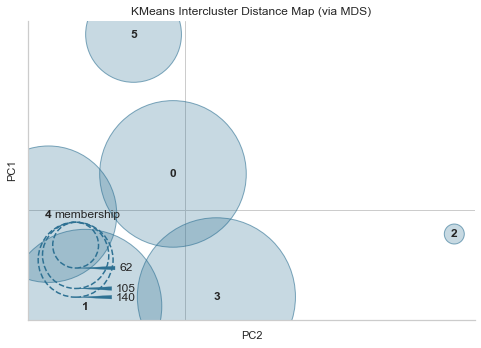

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [174]:
# Inter cluster distance map
from yellowbrick.cluster import InterclusterDistance
# Fit K-Means
kmeans_1 = KMeans(n_clusters=6,random_state= 10)
# Use fit_predict to cluster the dataset
predictions = kmeans_1.fit_predict(umap_df)
# Instantiate the clustering model and visualizer
visualizer = InterclusterDistance(kmeans_1)
visualizer.fit(umap_df)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

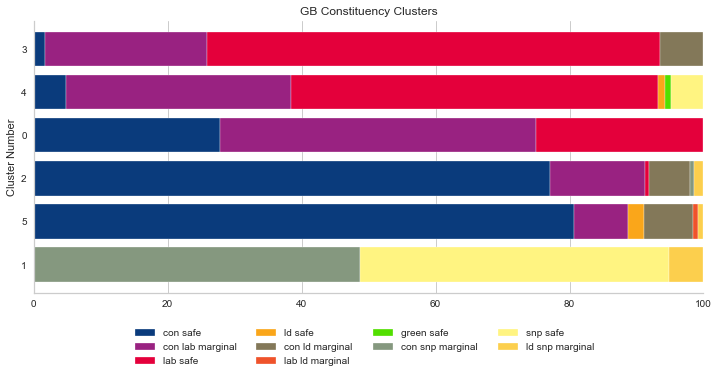

In [175]:
party_list = ['con safe','con lab marginal',
              'lab safe','ld safe',
              'con ld marginal','lab ld marginal',
              'green safe', 'con snp marginal', 'snp safe', 'ld snp marginal']

party_colors = [con_blue, con_lab, lab_red, lib_yel,
               con_lib, lab_lib, green_green, con_snp, snp_yel, lib_snp]

gb_cluster_yg_pivot=gb_cluster_yg_pivot.reindex(party_list)

gb_cluster_bar = (gb_cluster_yg_pivot / gb_cluster_yg_pivot.sum()).T.sort_values(by='lab safe', ascending=True)

gb_cluster_bar.plot.barh(stacked=True,
                          figsize=(12,5),
                          width=0.8,
                          color=party_colors)

plt.xticks(ticks = np.arange(0,1.2,0.2), labels = np.arange(0,120,20))
plt.xlim(0,1);

plt.title('GB Constituency Clusters');
plt.ylabel('Cluster Number')

plt.legend(bbox_to_anchor=(0.85, -0.1),
           ncol=4,
           frameon=False);

In [206]:
df_con.set_index('ID', inplace=True)

In [217]:
df_con.head(1)

,Constituency,Region,Type,Population,0-9,10-19,20-29,30-39,40-49,50-59,...,Depression,Obesity,Diabetes,Asthma,DiseasesPerPop,%LeaveVote,%17Turnout,Winner_17,seat_types_17,seat_types_yg
ID,,,,,,,,,,,,,,,,,,,,,
E14000554,Berwick-upon-Tweed,North East,Rural,75425,0.0863,0.0863,0.0902,0.1002,0.1102,0.1657,...,0.08551,0.13193,0.08029,0.07315,0.89389,0.553,0.719149,Con,con safe,con safe


In [223]:
constituency_clusters(gb_cluster_yg)

,ID,Constituency,seat_types_yg,Cluster
0,E14000554,Berwick-upon-Tweed,con safe,2
1,E14000569,Bishop Auckland,con lab marginal,0
2,E14000574,Blaydon,lab safe,0
3,E14000575,Blyth Valley,con lab marginal,0
4,E14000641,City of Durham,con lab marginal,4
...,...,...,...,...
626,W07000076,Caerphilly,lab safe,0
627,W07000077,Islwyn,lab safe,0
628,W07000078,Vale of Glamorgan,con lab marginal,2
629,W07000079,Cardiff West,lab safe,4


In [52]:
# pd.concat(y19_st_gb, pd.DataFrame(km_preds_gb[0],
#                                         index=y17_st_gb.index,
#                                         columns=['Cluster'])

In [53]:
# list(gb_cluster_yg[gb_cluster_yg['Colors'] == '#661D98'].index)

In [54]:
# df_con.Constituency.isin([df_con.ID.isin(list(gb_cluster_yg[gb_cluster_yg['Colors'] == '#661D98'].index))] == 'Manchester Central'

In [55]:
# l = []
# for i in gb_cluster_yg[gb_cluster_yg['Colors'] == '#661D98'].index:
#     if i[0] == 'S':
#         l.append(i)
        
# l

In [56]:
sn = gb_cluster_yg.filter(items = ['S14000022', 'S14000023', 'S14000024', 'S14000025', 'S14000029', 'S14000031'], axis=0)

In [58]:
# df_con[df_con.ID.isin(l)] # The labour safe seat can be targeted by the snp party or vice versa

In [59]:
df = df.filter(items = [2], axis=0)

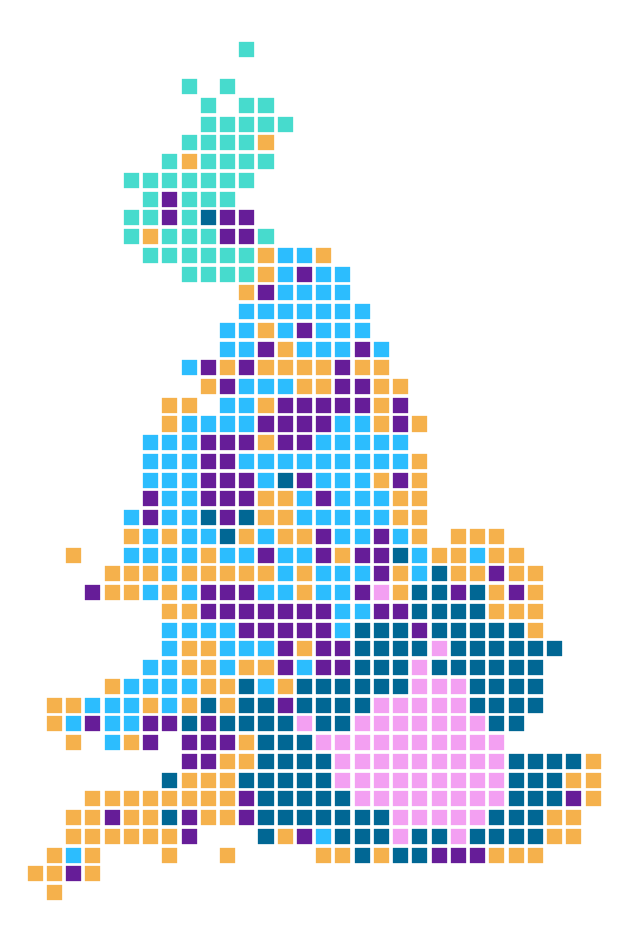

In [224]:
gb_cluster_yg['Colors'] = gb_cluster_yg['Cluster'].map(
    lambda x: color_list[x])

kpi_map('Population',
        colors=gb_cluster_yg[['Colors']],
        data=pd.read_csv('data_with_targets.csv').set_index('ID'),
        exc_color='#ffffff',
        exclude=['Northern Ireland'],
        width=11)

In [257]:
'K-Means' + '_' + 'UMAP'

'K-Means_UMAP'

In [ ]:
party_list = ['con safe','con lab marginal',
'lab safe','ld safe',
'con ld marginal','lab ld marginal',
'green safe', 'con snp marginal', 'snp safe', 'ld snp marginal']


party_colors = [con_blue, con_lab, lab_red, lib_yel,con_lib, lab_lib, 
                green_green, con_snp, snp_yel, lib_snp]


In [265]:
PCA_df_gb.shape

(631, 25)

In [400]:
def cluster_bar_visual(data):

    gb_cluster_bar = (data/ data.sum()).T.sort_values(by='lab safe', ascending=True)

    gb_cluster_bar.plot.barh(stacked=True,
                  figsize=(12,5),
                  width=0.8,
                  color=party_colors)

    plt.xticks(ticks = np.arange(0,1.2,0.2), labels = np.arange(0,120,20))
    plt.xlim(0,1);

    plt.title('GB Constituency Clusters');
    plt.ylabel('Cluster Number')

    plt.legend(bbox_to_anchor=(0.85, -0.1),
                   ncol=4,frameon=False)

In [541]:
gb_cluster_yg['Colors'] = gb_cluster_yg['Cluster'].map(
    lambda x: color_list[x])

# kpi_map('Population',
#         colors=gb_cluster_yg[['Colors']],
#         data=pd.read_csv('data_with_targets.csv').set_index('ID'),
#         exc_color='#ffffff',
#         exclude=['Northern Ireland'],
#         width=11)

def Map_cluster(df):
    kpi_map('Population',colors=df[['Colors']], data=df_con,
    exc_color='#ffffff',exclude=['Northern Ireland'], width=11)

In [527]:
# Split all clustering and metric visual options into different functions and run them inside the function below
# Makes it easier and produces cleaner code

In [382]:
# Before scaling
X_gb.head(1)

,0-19%,20-29%,30-59%,60+%,AreaKM2,Pop_Density,Businesses,%BusinessGrowth,BusinessesPer1kCap,%Unemployment,...,%Born_Asia,MbpsSpeed,%UnableDecent,%Under10Mbps,%LeaveVote,%17Turnout,con%,lab%,ld%,snp%
ID,,,,,,,,,,,,,,,,,,,,,
E14000554,0.1765,0.0902,0.3761,0.3556,2379.418011,31.698928,3500,0.136364,46.403712,0.028975,...,0.005507,29.6,0.06252,0.2489,0.553,0.719149,52.461385,24.55226,21.121956,0.0


In [535]:
def clustering_metrics(model, data): # yhat = model.fit(data)
    
    yhat = model.fit(data)
    yhat_2 = model.fit_predict(data)
    
    # retrieve unique clusters
    # Calculate cluster validation metrics
    score_AGclustering_s = silhouette_score(data, yhat.labels_, metric='euclidean')
    score_AGclustering_c = calinski_harabasz_score(data, yhat.labels_)
    score_AGclustering_d = davies_bouldin_score(data, yhat_2)

    print('Silhouette Score: %.4f' % score_AGclustering_s)
    print('Calinski Harabasz Score: %.4f' % score_AGclustering_c)
    print('Davies Bouldin Score: %.4f' % score_AGclustering_d)

# Clustering Algorithms

def K_Means(n_clusters, data):
    
    k_means = KMeans(n_clusters)
    k_means.fit(data)

    #Store the predicted labels
    km_preds_gb = []
    km_preds_gb.append(k_means.predict(data))
    
    clustering_metrics(k_means, data)
    
    return km_preds_gb
    


def HAC(n_clusters, data):
    
    #Instantiate and run a HAC algorithm
    HAC = AgglomerativeClustering(n_clusters)

    #Store the predicted labels
    hac_preds_gb = []
    hac_preds_gb.append(HAC.fit_predict(data))
    clustering_metrics(HAC, data)
    
    return hac_preds_gb

def DB_Clustering(ep, min_points, alg, data):
    
    db = DBSCAN(eps=float(ep), min_samples=float(min_points), algorithm=str(alg))
    #Store the predicted labels
    db_preds_gb = []
    preds = db.fit_predict(data)
    db_preds_gb.append(preds)
    clustering_metrics(db, data)
    
    # Fit the models
    clm46 = db.fit(data)
    # Print DBSCAN results
    print('*************** DBSCAN Clustering Model ***************')
    print("Cluster labels")
    print(np.unique(clm46.labels_))
    
    return db_preds_gb 


def Mean_Shift():
    pass

def AMM():
    pass

# Finalize the data function

def constituency_clusters(cluster_df, data):      
    dframe = pd.concat([data, cluster_df], join='inner', axis=1)[['Constituency', 'seat_types_yg', 'Colors', 'Cluster']]
    dframe = dframe.loc[:,~dframe.columns.duplicated()].reset_index()

    return dframe



# Metric Visuals

def Distortion_visual(model, data):
    visualizer = KElbowVisualizer(model, k=(2,18), timings= True)
    visualizer.fit(data)        # Fit data to visualizer
    visualizer.show()        # Finalize and render figure
    
def Calinski_Harabasz():
    pass
    
 
    
    
# Heatmap function

def kpi_heatmap(kpi_data, data):

    heatmap_cluster_kpis(kpis=kpi_data,data=X_gb,cmap=CB91_Grad_BWP[::-1],size=0.7, cluster_data=data)

    plt.title('Heatmap of English Constituency Clusters by KPI\n\
    (0.0=Lowest Cluster For That KPI, 1.0=Highest Cluster For That KPI)\n')
    plt.ylabel('Cluster Number')
    
    
def Map_cluster(data):
    kpi_map('Population',colors=data[['Colors']], data=data,
    exc_color='#ffffff',exclude=['Northern Ireland'], width=11)
    

def cluster_bar_visual(data):

    gb_cluster_bar = (data/ data.sum()).T.sort_values(by='lab safe', ascending=True)

    gb_cluster_bar.plot.barh(stacked=True,
                  figsize=(12,5),
                  width=0.8,
                  color=party_colors)

    plt.xticks(ticks = np.arange(0,1.2,0.2), labels = np.arange(0,120,20))
    plt.xlim(0,1);

    plt.title('GB Constituency Clusters');
    plt.ylabel('Cluster Number')

    plt.legend(bbox_to_anchor=(0.85, -0.1),
                   ncol=4,frameon=False)

In [536]:
def cluster_dataframes(preds):
    
    gb_cluster_yg = pd.concat([y19_st_gb,
                       pd.DataFrame(preds[0],
                                    index=y17_st_gb.index,
                                    columns=['Cluster'])],
                       axis=1)

    gb_cluster_yg_pivot = pd.pivot_table(data = gb_cluster_yg,
                                             index='seat_types_yg',
                                             columns='Cluster',
                                             aggfunc=len,
                                             fill_value=0)
    
    gb_cluster_yg_pivot = gb_cluster_yg_pivot.reindex(party_list)
    
    return gb_cluster_yg, gb_cluster_yg_pivot

In [537]:
def DBScan_func(dim_red, metric):

    score = []
    # Define ranges to explore
    eps_range=range(3, 11)  
    minpts_range=range(3,11)
    
    for k in eps_range:
        for j in minpts_range:
            for x in ['auto', 'ball_tree', 'kd_tree', 'brute']:
            
                if str(dim_red) == 'PCA':
                    model = DBSCAN(eps=k, min_samples=j, algorithm=x)
                    clm = model.fit(PCA_df_gb)
                    score_d = metrics.davies_bouldin_score(PCA_df_gb, clm.labels_)
                    score_s = metrics.silhouette_score(PCA_df_gb, clm.labels_, metric='euclidean')
                    score_h = metrics.calinski_harabasz_score(PCA_df_gb, clm.labels_)
                    score.append((k, j, score_d, score_s, score_h, x))

                elif str(dim_red) == 'UMAP':
                    model = DBSCAN(eps=k/10, min_samples=j)
                    clm = model.fit(umap_df)
                    score_d = metrics.davies_bouldin_score(umap_df, clm.labels_)
                    score_s = metrics.silhouette_score(umap_df, clm.labels_, metric='euclidean')
                    score_h = metrics.calinski_harabasz_score(umap_df, clm.labels_)
                    score.append((k/10, j, score_d, score_s, score_h, x))
                
    score_1 = pd.DataFrame(score)
    score_1.columns = ['Epsilon', 'Minimum_points', 'Davies_Bouldin_Score', 'Silhouette_Score', 'Calinski_Harabasz', 'Algorithm']
    
    if str(metric) == 'Davies Bouldin':
        score_2 = score_1[score_1.Davies_Bouldin_Score == score_1.Davies_Bouldin_Score.min()]
        
    elif str(metric) == 'Silhouette':
        score_2 = score_1[score_1.Silhouette_Score == score_1.Silhouette_Score.max()] 
        
    elif str(metric) == 'Calinski':
        score_2 = score_1[score_1.Calinski_Harabasz == score_1.Calinski_Harabasz.max()]
    
    return score_2.head(2)

In [516]:
DBScan_func('PCA', 'Calinski')

,Epsilon,Minimum_points,Davies_Bouldin_Score,Silhouette_Score,Calinski_Harabasz,Algorithm
80,5,7,1.687376,0.178797,96.763527,auto
81,5,7,1.687376,0.178797,96.763527,ball_tree


In [542]:
def WDSS_clustering(data, dim_reduction, clustering_method, metric_visuals=False, map_plot=False, cluster_bar=False,
                   metric=None, heatmap=False):
    
    
    if clustering_method == 'KMeans':
        model = KMeans()
      
        if dim_reduction == 'PCA':
            if metric_visuals == True:
                Distortion_visual(model, PCA_df_gb)
            n_clust = int(input("Enter number of clusters: "))
            preds_gb = K_Means(n_clust, PCA_df_gb)
            
        elif dim_reduction == 'UMAP':
            if metric_visuals == True:
                Distortion_visual(model, umap_df)
            n_clust = int(input("Enter number of clusters: "))
            preds_gb = K_Means(n_clust, umap_df)
            
    elif clustering_method == 'HAC':
        model = AgglomerativeClustering()
        
        if dim_reduction == 'PCA':
            if metric_visuals == True:
                Distortion_visual(model, PCA_df_gb)
            n_clust = int(input("Enter number of clusters: "))
            preds_gb = HAC(n_clust, PCA_df_gb)
            
        elif dim_reduction == 'UMAP':
            if metric_visuals == True:
                Distortion_visual(model, umap_df)
            n_clust = int(input("Enter number of clusters: "))
            preds_gb = HAC(n_clust, umap_df)
            
    elif clustering_method == 'DBScan':  
        if dim_reduction == 'PCA':
            if metric_visuals == True:
                metr = input("Please input the metric of your choice from ['Davies Bouldin', 'Silhouette', 'Calinski']: ")
                display(DBScan_func('PCA', metr))

            ep = input("Enter epsilon value from 3 or above: ")
            mns = input("Enter minimum samples value from 3 or above: ")
            algo = input("Enter algorithm type from the list: [‘auto’, ‘ball_tree’, ‘kd_tree’, ‘brute’]: ")
            preds_gb = DB_Clustering(ep, mns, algo, PCA_df_gb)
            
            
        if dim_reduction == 'UMAP':
            if metric_visuals == True:
                metr = input("Please input the metric of your choice from ['Davies Bouldin', 'Silhouette', 'Calinski']: ")
                display(DBScan_func('UMAP', metr))

            ep = input("Enter epsilon value from 3 or above: ")
            mns = input("Enter minimum samples value from 3 or above: ")
            algo = input("Enter algorithm type from the list: [‘auto’, ‘ball_tree’, ‘kd_tree’, ‘brute’]: ")
            preds_gb = DB_Clustering(ep, mns, algo, umap_df)

            
    gb_cluster_yg, gb_cluster_yg_pivot = cluster_dataframes(preds_gb)

    if cluster_bar == True:
        cluster_bar_visual(gb_cluster_yg_pivot)

    else:
        pass

    gb_cluster_yg['Colors'] = gb_cluster_yg['Cluster'].map(lambda x: color_list[x])

    if map_plot == True:
        Map_cluster(gb_cluster_yg)

    df = constituency_clusters(gb_cluster_yg, data)
    
    
    #Define a standard list of KPIs to look at
    
    if heatmap == True:

        kpis_gb = ['Pop_Density','2019_Wage', 'HousePricePerWage', '%HousePriceGrowth','%OwnOutright','%OwnWithMort',
              '%PrivateRent','%SocialHousing','%Unemployment', 'UnemploymentChange',
              '%Heavy Industry & Manufacturing', '%Wholesale & Retail',
              '%FS & ICT', '%White', '%Muslim', '%BornUK','%Level4+', '%LeaveVote', 'con%', 'snp%']
            
        kpi_heatmap(kpis_gb, gb_cluster_yg)
        
    return df

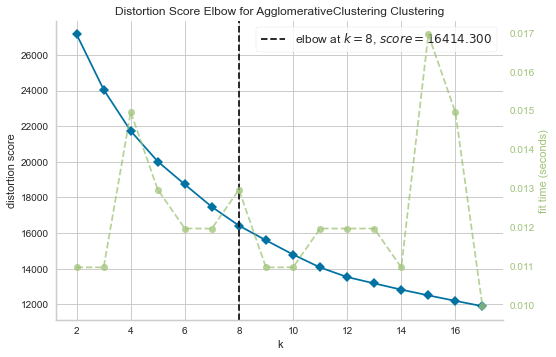

Enter number of clusters: 2
Silhouette Score: 0.4431
Calinski Harabasz Score: 170.6913
Davies Bouldin Score: 1.1578


,ID,Constituency,seat_types_yg,Colors,Cluster
0,E14000554,Berwick-upon-Tweed,con safe,#2CBDFE,0
1,E14000569,Bishop Auckland,con lab marginal,#2CBDFE,0
2,E14000574,Blaydon,lab safe,#2CBDFE,0
3,E14000575,Blyth Valley,con lab marginal,#2CBDFE,0
4,E14000641,City of Durham,con lab marginal,#2CBDFE,0
5,E14000658,Darlington,con lab marginal,#2CBDFE,0
6,E14000677,Easington,lab safe,#2CBDFE,0
7,E14000709,Gateshead,lab safe,#2CBDFE,0
8,E14000733,Hartlepool,con lab marginal,#2CBDFE,0
9,E14000746,Hexham,con safe,#2CBDFE,0


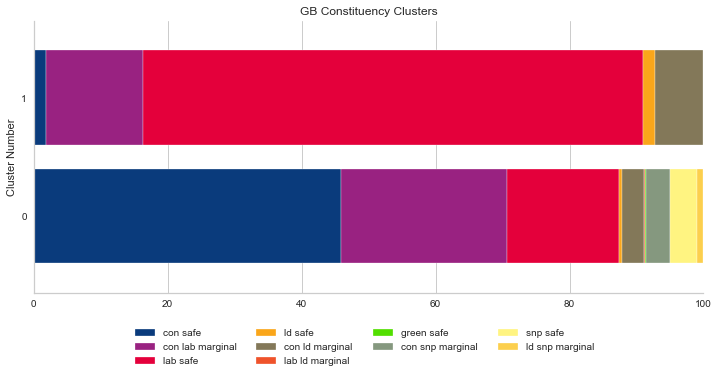

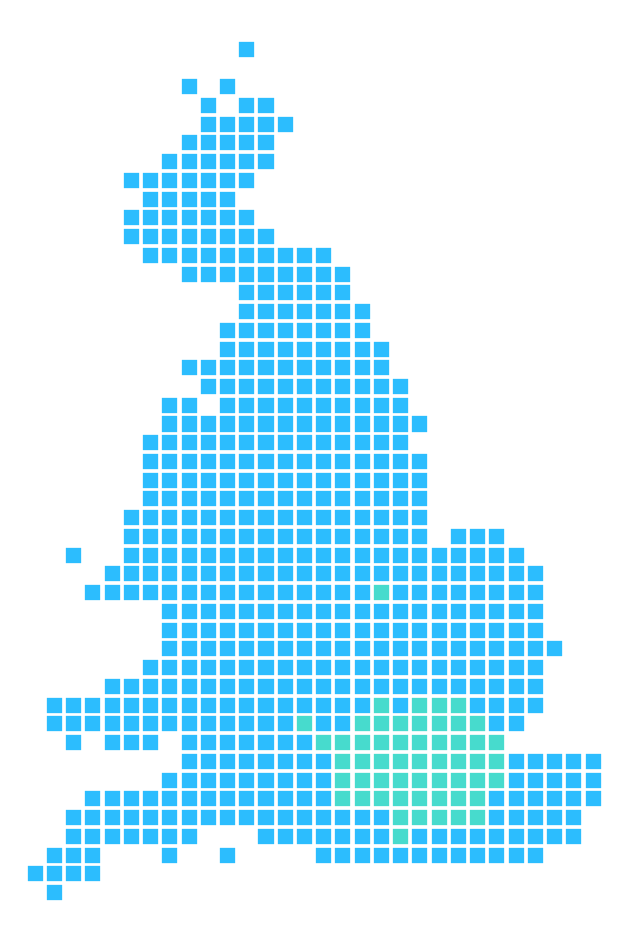

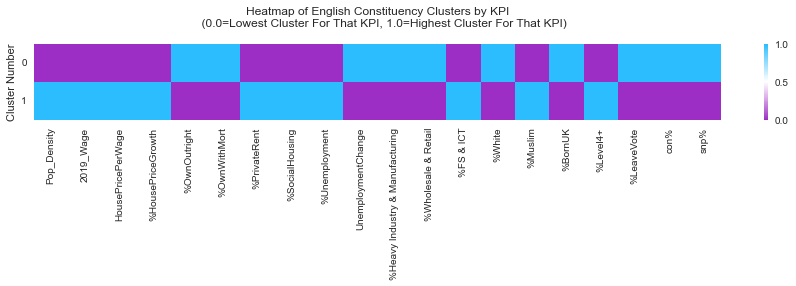

In [589]:
dat = WDSS_clustering(data=df_con, dim_reduction='PCA', clustering_method='HAC', map_plot=True, metric_visuals=True,
                     cluster_bar=True, heatmap=True)
dat.head(10)

In [590]:
dat.to_csv('PCA_HAC_2.csv')

In [259]:
d = constituency_clusters(gb_cluster_yg, df_con)

In [260]:
d.loc[d['Constituency'].str.contains("Edinburgh"), :]

,ID,Constituency,seat_types_yg,Colors,Cluster
553,S14000022,Edinburgh East,snp safe,#661D98,4
554,S14000023,Edinburgh North and Leith,snp safe,#661D98,4
555,S14000024,Edinburgh South,lab safe,#661D98,4
556,S14000025,Edinburgh South West,snp safe,#661D98,4
557,S14000026,Edinburgh West,ld snp marginal,#016794,5


In [236]:
nam = 'Williams'

nam.startswith('W')

True

In [356]:
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score


# define the model
model = KMeans(n_clusters=6)

# fit model and predict clusters
yhat = model.fit(umap_df)
yhat_2 = model.fit_predict(umap_df)

# retrieve unique clusters
clusters = np.unique(yhat)

# Calculate cluster validation metrics
score_AGclustering_s = silhouette_score(PCA_df_gb, yhat.labels_, metric='euclidean')
score_AGclustering_c = calinski_harabasz_score(PCA_df_gb, yhat.labels_)
score_AGclustering_d = davies_bouldin_score(PCA_df_gb, yhat_2)

print('Silhouette Score: %.4f' % score_AGclustering_s)
print('Calinski Harabasz Score: %.4f' % score_AGclustering_c)
print('Davies Bouldin Score: %.4f' % score_AGclustering_d)

Silhouette Score: 0.1275
Calinski Harabasz Score: 106.2539
Davies Bouldin Score: 1.6639


#### PCA

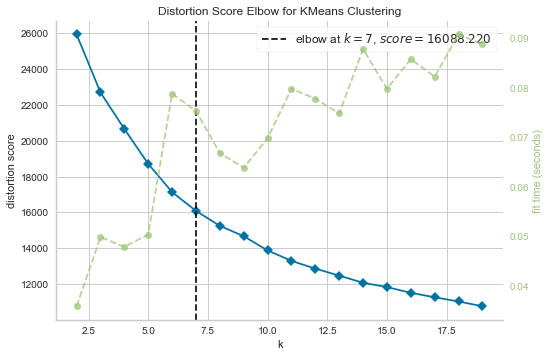

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [62]:
import yellowbrick

# Distortion Score

# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,20), timings= True)
visualizer.fit(PCA_df_gb)        # Fit data to visualizer
visualizer.show()        # Finalize and render figure

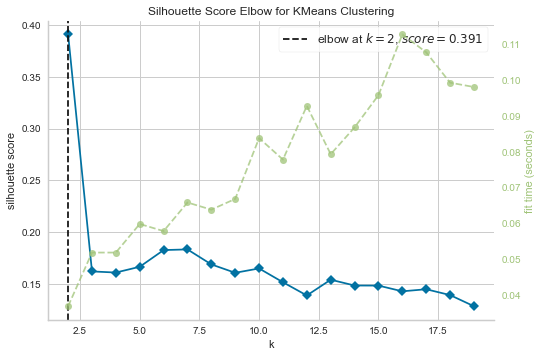

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [63]:
# Silhouette Score

# Silhouette Coefficient is calculated using the mean intracluster distance (d1) and mean nearest cluster distance (d2)
# (d2 - d1) / max(d2 - d1)
# Silhouette Score for K means
# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,20),metric='silhouette', timings= True)
visualizer.fit(PCA_df_gb)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

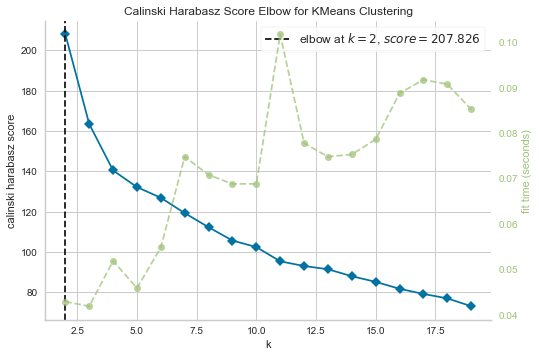

<AxesSubplot:title={'center':'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [64]:
# Calinski Harabasz Score for K means
# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,20),metric='calinski_harabasz', timings= True)
visualizer.fit(PCA_df_gb)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

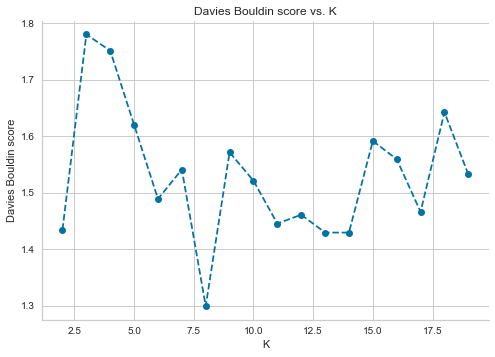

In [65]:
# Davies Bouldin Score
# Davies Bouldin Index - need at least 2 points in each cluster
# As DB Index falls, clustering improves
# Davies Bouldin score for K means
from sklearn.metrics import davies_bouldin_score
def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding Davies Bouldin for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the Davies Bouldin score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters=center)
# Then fit the model to your data using the fit method
    model = kmeans.fit_predict(data)
    
    # Calculate Davies Bouldin score
    score = davies_bouldin_score(data, model)
    
    return score

scores = []
centers = list(range(2,20))
for center in centers:
    scores.append(get_kmeans_score(PCA_df_gb, center))


    
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
# plt.vlines(x=6, ymin=0.0, ymax=min(scores), linestyle='--', color='r')
# plt.hlines(y=min(scores), xmin=0, xmax=6, linestyle='--', color='r')
plt.ylabel('Davies Bouldin score');
plt.title('Davies Bouldin score vs. K');
# plt.xlim(1.6, 20)
# plt.ylim(0.7, 1.25)

# 8 Clusters with Davies Bouldin

####  Clusters analysis

In [67]:
# We will go with the distortion score of 7 as it is more consistent throughout all the dimensionality reduction methods

#Instantiate and run a KMeans algorithm
k_means = KMeans(n_clusters=7)
k_means.fit(PCA_df_gb)

#Store the predicted labels
km_preds_gb = []
km_preds_gb.append(k_means.predict(PCA_df_gb))

gb_cluster_yg = pd.concat([y19_st_gb,
                           pd.DataFrame(km_preds_gb[0], # We choose 7 clusters
                                        index=y17_st_gb.index,
                                        columns=['Cluster'])],
                           axis=1)

gb_cluster_yg_pivot = pd.pivot_table(data = gb_cluster_yg,
                                     index='seat_types_yg',
                                     columns='Cluster',
                                     aggfunc=len,
                                     fill_value=0)

gb_cluster_yg_pivot

Cluster,0,1,2,3,4,5,6
seat_types_yg,,,,,,,
con lab marginal,82,8,4,6,0,20,27
con ld marginal,0,0,4,0,0,10,8
con pc marginal,0,0,0,0,0,0,1
con safe,55,0,1,0,0,83,120
con snp marginal,0,0,0,0,19,1,0
green safe,0,1,0,0,0,0,0
lab ld marginal,0,0,0,0,0,1,0
lab safe,55,22,23,30,0,4,1
lab snp marginal,0,0,0,0,10,0,0


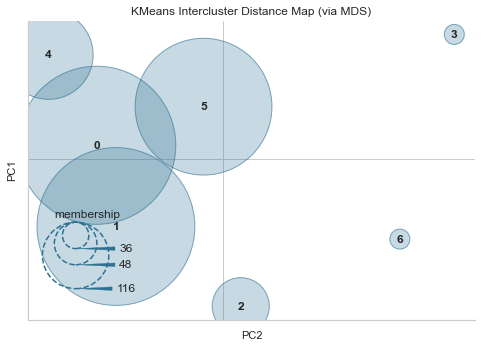

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [68]:
# Inter cluster distance map
from yellowbrick.cluster import InterclusterDistance
# Fit K-Means
kmeans_1 = KMeans(n_clusters=7,random_state= 10)
# Use fit_predict to cluster the dataset
predictions = kmeans_1.fit_predict(PCA_df_gb)
# Instantiate the clustering model and visualizer
visualizer = InterclusterDistance(kmeans_1)
visualizer.fit(PCA_df_gb)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

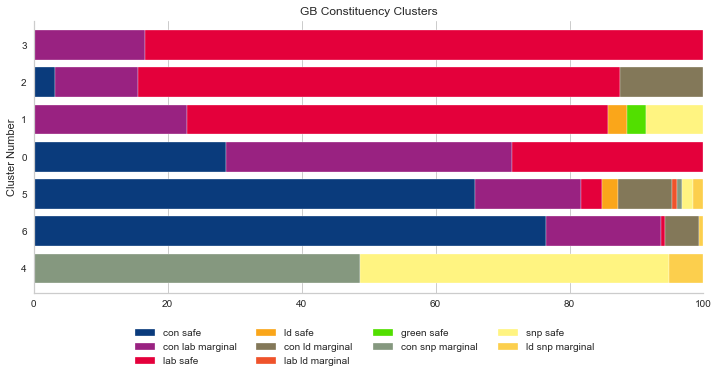

In [69]:
party_list = ['con safe','con lab marginal',
              'lab safe','ld safe',
              'con ld marginal','lab ld marginal',
              'green safe', 'con snp marginal', 'snp safe', 'ld snp marginal']

party_colors = [con_blue, con_lab, lab_red, lib_yel,
               con_lib, lab_lib, green_green, con_snp, snp_yel, lib_snp]

gb_cluster_yg_pivot=gb_cluster_yg_pivot.reindex(party_list)

gb_cluster_bar = (gb_cluster_yg_pivot / gb_cluster_yg_pivot.sum()).T.sort_values(by='lab safe', ascending=True)

gb_cluster_bar.plot.barh(stacked=True,
                          figsize=(12,5),
                          width=0.8,
                          color=party_colors)

plt.xticks(ticks = np.arange(0,1.2,0.2), labels = np.arange(0,120,20))
plt.xlim(0,1);

plt.title('GB Constituency Clusters');
plt.ylabel('Cluster Number')

plt.legend(bbox_to_anchor=(0.85, -0.1),
           ncol=4,
           frameon=False);

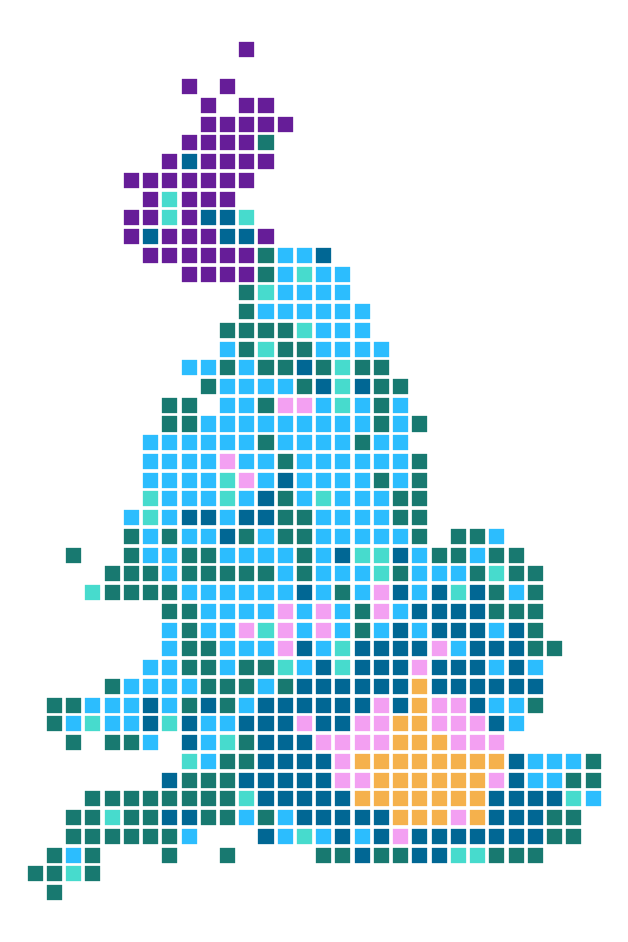

In [70]:
gb_cluster_yg['Colors'] = gb_cluster_yg['Cluster'].map(
    lambda x: color_list[x])

kpi_map('Population',
        colors=gb_cluster_yg[['Colors']],
        data=pd.read_csv('data_with_targets.csv').set_index('ID'),
        exc_color='#ffffff',
        exclude=['Northern Ireland'],
        width=11)

In [71]:
#Define a standard list of KPIs to look at
kpis_gb=['Pop_Density',
      '2019_Wage', 'HousePricePerWage', '%HousePriceGrowth',
      '%OwnOutright','%OwnWithMort', '%PrivateRent',
      '%SocialHousing','%Unemployment', 'UnemploymentChange',
      '%Heavy Industry & Manufacturing', '%Wholesale & Retail',
      '%FS & ICT', '%White', '%Muslim', '%BornUK',
      '%Level4+', '%LeaveVote', 'con%']

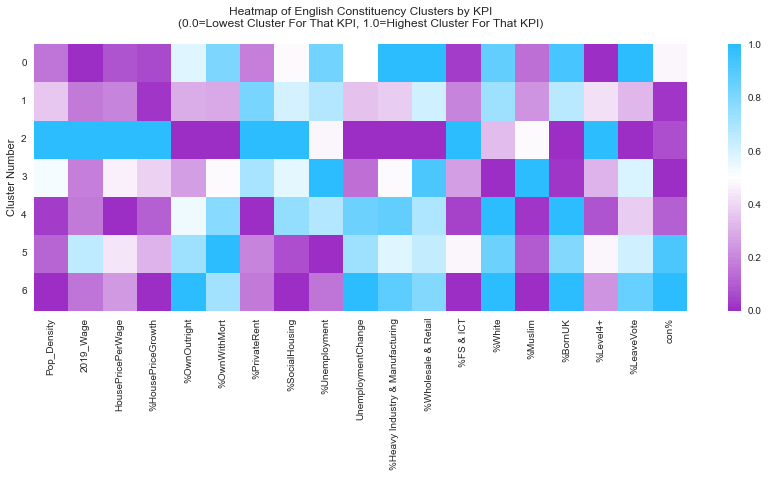

In [72]:
#Define a standard list of KPIs to look at
kpis_gb=['Pop_Density',
      '2019_Wage', 'HousePricePerWage', '%HousePriceGrowth',
      '%OwnOutright','%OwnWithMort', '%PrivateRent',
      '%SocialHousing','%Unemployment', 'UnemploymentChange',
      '%Heavy Industry & Manufacturing', '%Wholesale & Retail',
      '%FS & ICT', '%White', '%Muslim', '%BornUK',
      '%Level4+', '%LeaveVote', 'con%']

heatmap_cluster_kpis(kpis=kpis_gb,
        data=X_gb,cmap=CB91_Grad_BWP[::-1],size=0.7,
        cluster_data=gb_cluster_yg)

plt.title('Heatmap of English Constituency Clusters by KPI\n\
(0.0=Lowest Cluster For That KPI, 1.0=Highest Cluster For That KPI)\n')
plt.ylabel('Cluster Number');

In [73]:
# define the model
model = KMeans(n_clusters=7)

# fit model and predict clusters
yhat = model.fit(PCA_df_gb)
yhat_2 = model.fit_predict(PCA_df_gb)

# retrieve unique clusters
clusters = np.unique(yhat)

# Calculate cluster validation metrics
score_AGclustering_s = silhouette_score(PCA_df_gb, yhat.labels_, metric='euclidean')
score_AGclustering_c = calinski_harabasz_score(PCA_df_gb, yhat.labels_)
score_AGclustering_d = davies_bouldin_score(PCA_df_gb, yhat_2)

print('Silhouette Score: %.4f' % score_AGclustering_s)
print('Calinski Harabasz Score: %.4f' % score_AGclustering_c)
print('Davies Bouldin Score: %.4f' % score_AGclustering_d)

Silhouette Score: 0.1839
Calinski Harabasz Score: 119.3007
Davies Bouldin Score: 1.4528


### HAC

#### UMAP

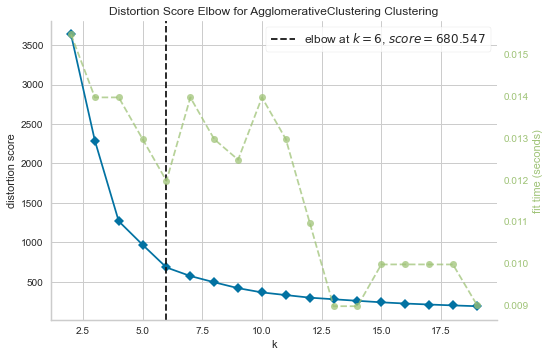

<AxesSubplot:title={'center':'Distortion Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='distortion score'>

In [74]:
# Elbow Method for HAC
# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = AgglomerativeClustering()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,20), timings= True)
visualizer.fit(umap_df)        # Fit data to visualizer
visualizer.show()        # Finalize and render figure

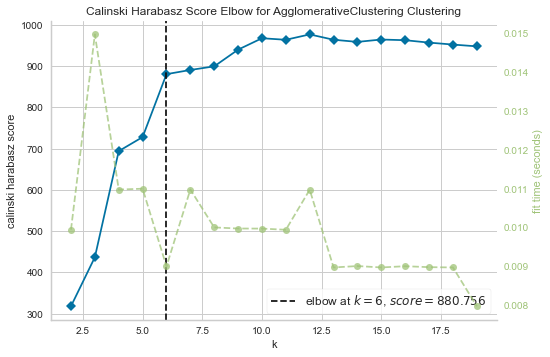

<AxesSubplot:title={'center':'Calinski Harabasz Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [75]:
# Calinski Harabasz Score for HAC
model = AgglomerativeClustering()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,20),metric='calinski_harabasz', timings= True)
visualizer.fit(umap_df)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

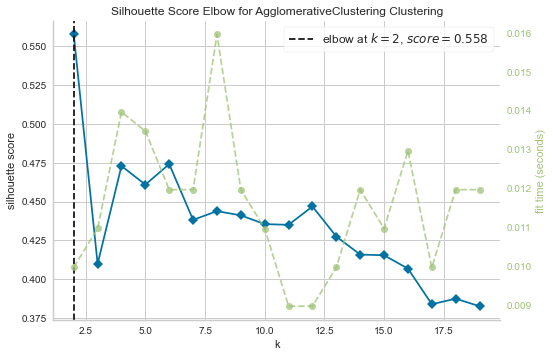

<AxesSubplot:title={'center':'Silhouette Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='silhouette score'>

In [76]:
# Silhouette Score for HAC
model = AgglomerativeClustering()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,20),metric='silhouette', timings= True)
visualizer.fit(umap_df)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

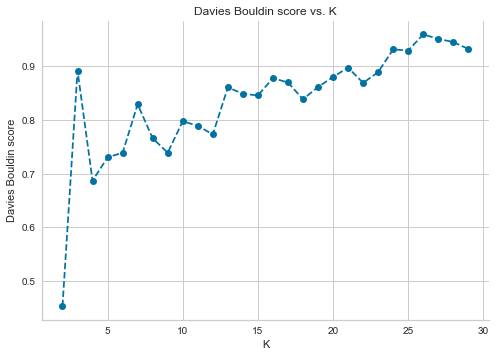

In [77]:
# Davies Bouldin score for HAC
from sklearn.metrics import davies_bouldin_score
def get_hac_score(data, center):
    '''
    returns the kmeans score regarding Davies Bouldin for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the Davies Bouldin score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    AC = AgglomerativeClustering(n_clusters=center)
    # Then fit the model to your data using the fit method
    model = AC.fit_predict(data)
    
    # Calculate Davies Bouldin score
    score = davies_bouldin_score(data, model)
    
    return score

scores = []
centers = list(range(2,30))
for center in centers:
    scores.append(get_hac_score(umap_df, center))
    
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('Davies Bouldin score');
plt.title('Davies Bouldin score vs. K');


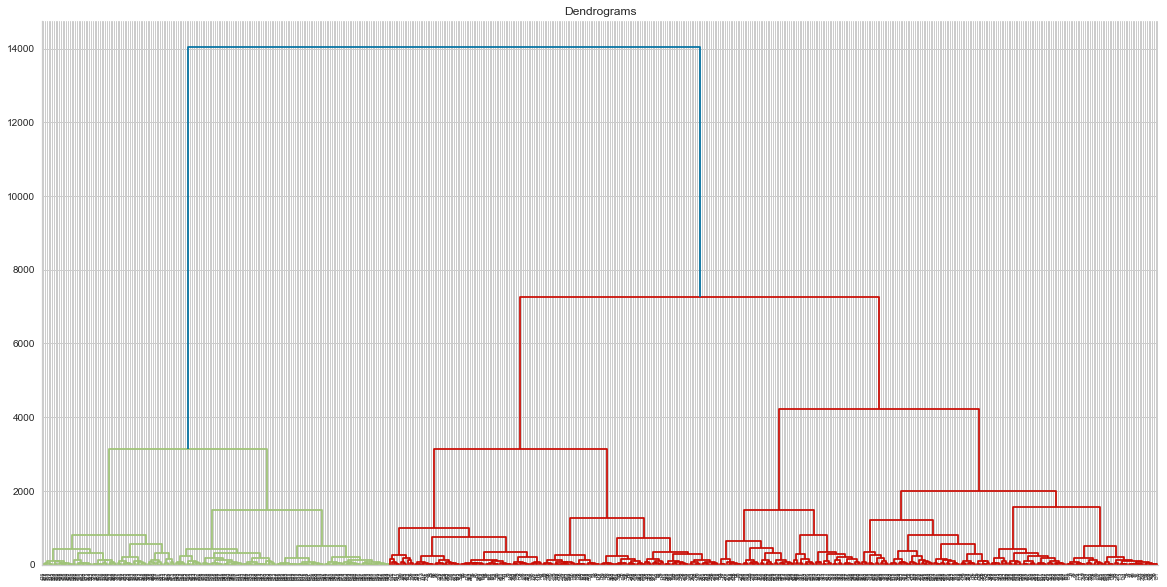

In [78]:
# Dendogram for Heirarchical Clustering
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster import hierarchy

 
model = AgglomerativeClustering()
model = model.fit(umap_df)
Z = hierarchy.linkage(model.children_, 'ward')
plt.figure(figsize=(20,10))
plt.title("Dendrograms") 
dn = hierarchy.dendrogram(Z)

In [79]:
# define the model - We will go with 6 clusters
model = AgglomerativeClustering(n_clusters=6)

# fit model and predict clusters
yhat = model.fit(umap_df)
yhat_2 = model.fit_predict(umap_df)

# retrieve unique clusters
clusters = np.unique(yhat)

# Calculate cluster validation metrics
score_AGclustering_s = silhouette_score(umap_df, yhat.labels_, metric='euclidean')
score_AGclustering_c = calinski_harabasz_score(umap_df, yhat.labels_)
score_AGclustering_d = davies_bouldin_score(umap_df, yhat_2)

print('Silhouette Score: %.4f' % score_AGclustering_s)
print('Calinski Harabasz Score: %.4f' % score_AGclustering_c)
print('Davies Bouldin Score: %.4f' % score_AGclustering_d)

Silhouette Score: 0.4741
Calinski Harabasz Score: 880.7557
Davies Bouldin Score: 0.7387


In [80]:
#Instantiate and run a HAC algorithm
model = AgglomerativeClustering(n_clusters=6)

#Store the predicted labels
hac_preds_gb = []
hac_preds_gb.append(model.fit_predict(umap_df))

gb_cluster_yg = pd.concat([y19_st_gb,
                           pd.DataFrame(hac_preds_gb[0], # We choose 7 clusters
                                        index=y17_st_gb.index,
                                        columns=['Cluster'])],
                           axis=1)

gb_cluster_yg_pivot = pd.pivot_table(data = gb_cluster_yg,
                                     index='seat_types_yg',
                                     columns='Cluster',
                                     aggfunc=len,
                                     fill_value=0)

gb_cluster_yg_pivot

Cluster,0,1,2,3,4,5
seat_types_yg,,,,,,
con lab marginal,21,14,38,0,63,11
con ld marginal,10,9,0,0,0,3
con pc marginal,1,0,0,0,0,0
con safe,137,78,4,0,39,1
con snp marginal,1,0,0,19,0,0
green safe,0,0,1,0,0,0
lab ld marginal,0,1,0,0,0,0
lab safe,1,0,57,0,35,42
lab snp marginal,0,0,0,10,0,0


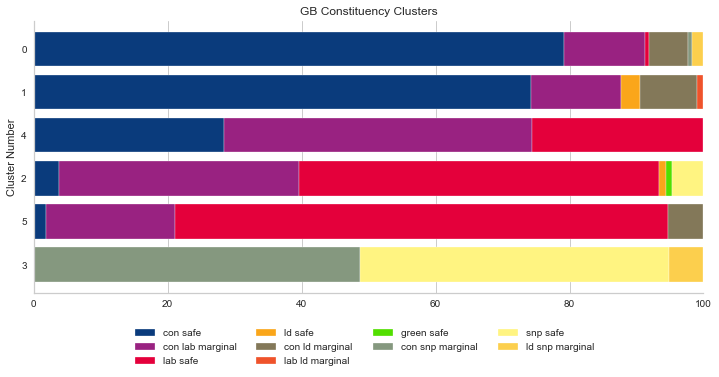

In [81]:
party_list = ['con safe','con lab marginal',
              'lab safe','ld safe',
              'con ld marginal','lab ld marginal',
              'green safe', 'con snp marginal', 'snp safe', 'ld snp marginal']

party_colors = [con_blue, con_lab, lab_red, lib_yel,
               con_lib, lab_lib, green_green, con_snp, snp_yel, lib_snp]

gb_cluster_yg_pivot=gb_cluster_yg_pivot.reindex(party_list)

gb_cluster_bar = (gb_cluster_yg_pivot / gb_cluster_yg_pivot.sum()).T.sort_values(by='con safe', ascending=True)

gb_cluster_bar.plot.barh(stacked=True,
                          figsize=(12,5),
                          width=0.8,
                          color=party_colors)

plt.xticks(ticks = np.arange(0,1.2,0.2), labels = np.arange(0,120,20))
plt.xlim(0,1);

plt.title('GB Constituency Clusters');
plt.ylabel('Cluster Number')

plt.legend(bbox_to_anchor=(0.85, -0.1),
           ncol=4,
           frameon=False);

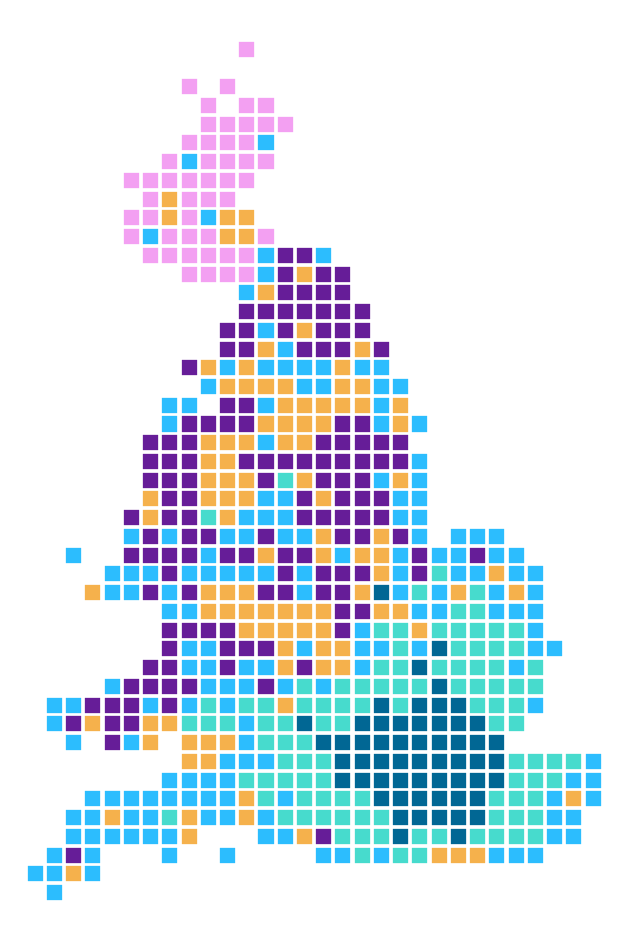

In [82]:
gb_cluster_yg['Colors'] = gb_cluster_yg['Cluster'].map(
    lambda x: color_list[x])

kpi_map('Population',
        colors=gb_cluster_yg[['Colors']],
        data=pd.read_csv('data_with_targets.csv').set_index('ID'),
        exc_color='#ffffff',
        exclude=['Northern Ireland'],
        width=11)

#### PCA

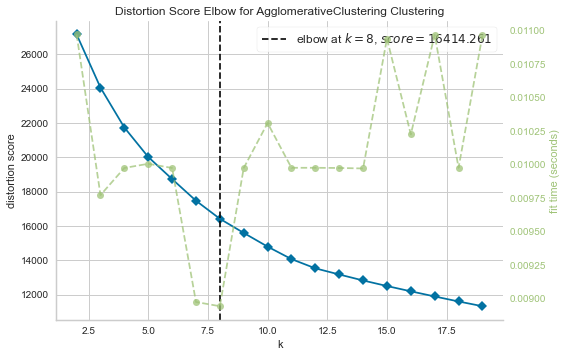

<AxesSubplot:title={'center':'Distortion Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='distortion score'>

In [83]:
# Elbow Method for HAC
# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = AgglomerativeClustering()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,20), timings= True)
visualizer.fit(PCA_df_gb)        # Fit data to visualizer
visualizer.show()        # Finalize and render figure

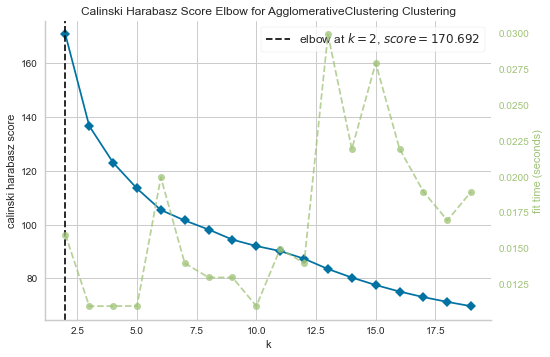

<AxesSubplot:title={'center':'Calinski Harabasz Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [84]:
# Calinski Harabasz Score for HAC
model = AgglomerativeClustering()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,20),metric='calinski_harabasz', timings= True)
visualizer.fit(PCA_df_gb)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

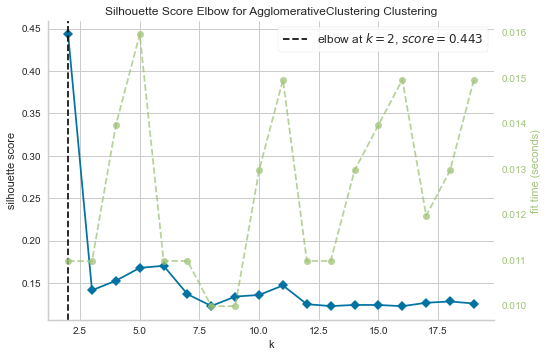

<AxesSubplot:title={'center':'Silhouette Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='silhouette score'>

In [85]:
# Silhouette Score for HAC
model = AgglomerativeClustering()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,20),metric='silhouette', timings= True)
visualizer.fit(PCA_df_gb)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

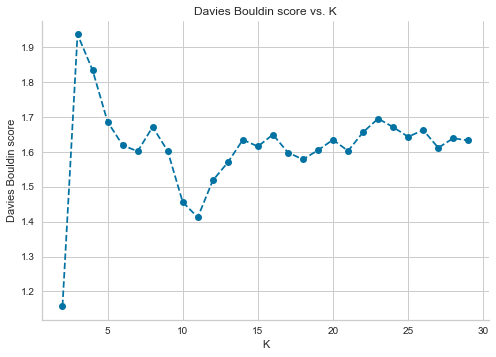

In [86]:
# Davies Bouldin score for HAC
from sklearn.metrics import davies_bouldin_score
def get_hac_score(data, center):
    '''
    returns the kmeans score regarding Davies Bouldin for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the Davies Bouldin score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    AC = AgglomerativeClustering(n_clusters=center)
    # Then fit the model to your data using the fit method
    model = AC.fit_predict(data)
    
    # Calculate Davies Bouldin score
    score = davies_bouldin_score(data, model)
    
    return score

scores = []
centers = list(range(2,30))
for center in centers:
    scores.append(get_hac_score(PCA_df_gb, center))
    
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('Davies Bouldin score');
plt.title('Davies Bouldin score vs. K');


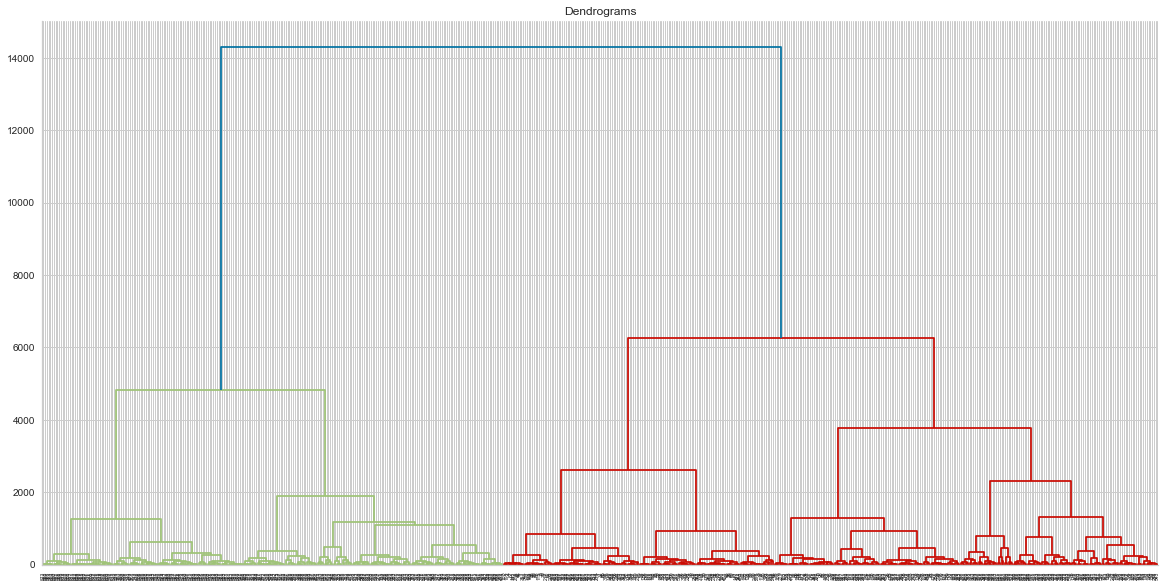

In [87]:
# Dendogram for Heirarchical Clustering
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster import hierarchy

 
model = AgglomerativeClustering()
model = model.fit(PCA_df_gb)
Z = hierarchy.linkage(model.children_, 'ward')
plt.figure(figsize=(20,10))
plt.title("Dendrograms") 
dn = hierarchy.dendrogram(Z)

In [88]:
# define the model - We will go with 8 clusters
model = AgglomerativeClustering(n_clusters=8)

# fit model and predict clusters
yhat = model.fit(PCA_df_gb)
yhat_2 = model.fit_predict(PCA_df_gb)

# retrieve unique clusters
clusters = np.unique(yhat)

# Calculate cluster validation metrics
score_AGclustering_s = silhouette_score(PCA_df_gb, yhat.labels_, metric='euclidean')
score_AGclustering_c = calinski_harabasz_score(PCA_df_gb, yhat.labels_)
score_AGclustering_d = davies_bouldin_score(PCA_df_gb, yhat_2)

print('Silhouette Score: %.4f' % score_AGclustering_s)
print('Calinski Harabasz Score: %.4f' % score_AGclustering_c)
print('Davies Bouldin Score: %.4f' % score_AGclustering_d)

Silhouette Score: 0.1228
Calinski Harabasz Score: 98.1733
Davies Bouldin Score: 1.6709


#### Clustering Analysis

In [89]:
#Instantiate and run a HAC algorithm
model = AgglomerativeClustering(n_clusters=8)

#Store the predicted labels
hac_preds_gb = []
hac_preds_gb.append(model.fit_predict(PCA_df_gb))

gb_cluster_yg = pd.concat([y19_st_gb,
                           pd.DataFrame(hac_preds_gb[0], # We choose 7 clusters
                                        index=y17_st_gb.index,
                                        columns=['Cluster'])],
                           axis=1)

gb_cluster_yg_pivot = pd.pivot_table(data = gb_cluster_yg,
                                     index='seat_types_yg',
                                     columns='Cluster',
                                     aggfunc=len,
                                     fill_value=0)

gb_cluster_yg_pivot

Cluster,0,1,2,3,4,5,6,7
seat_types_yg,,,,,,,,
con lab marginal,39,0,5,9,40,3,0,51
con ld marginal,1,0,4,0,6,0,11,0
con pc marginal,0,0,0,0,1,0,0,0
con safe,41,0,1,0,120,0,73,24
con snp marginal,0,19,0,0,0,0,1,0
green safe,0,0,0,1,0,0,0,0
lab ld marginal,0,0,0,0,0,0,1,0
lab safe,33,0,22,25,2,19,0,34
lab snp marginal,0,10,0,0,0,0,0,0


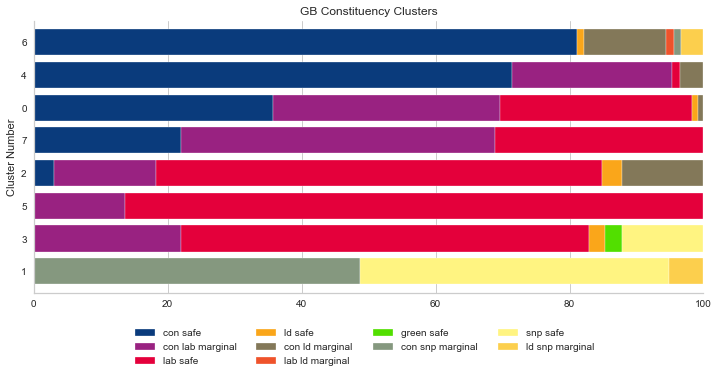

In [90]:
party_list = ['con safe','con lab marginal',
              'lab safe','ld safe',
              'con ld marginal','lab ld marginal',
              'green safe', 'con snp marginal', 'snp safe', 'ld snp marginal']

party_colors = [con_blue, con_lab, lab_red, lib_yel,
               con_lib, lab_lib, green_green, con_snp, snp_yel, lib_snp]

gb_cluster_yg_pivot=gb_cluster_yg_pivot.reindex(party_list)

gb_cluster_bar = (gb_cluster_yg_pivot / gb_cluster_yg_pivot.sum()).T.sort_values(by='con safe', ascending=True)

gb_cluster_bar.plot.barh(stacked=True,
                          figsize=(12,5),
                          width=0.8,
                          color=party_colors)

plt.xticks(ticks = np.arange(0,1.2,0.2), labels = np.arange(0,120,20))
plt.xlim(0,1);

plt.title('GB Constituency Clusters');
plt.ylabel('Cluster Number')

plt.legend(bbox_to_anchor=(0.85, -0.1),
           ncol=4,
           frameon=False);

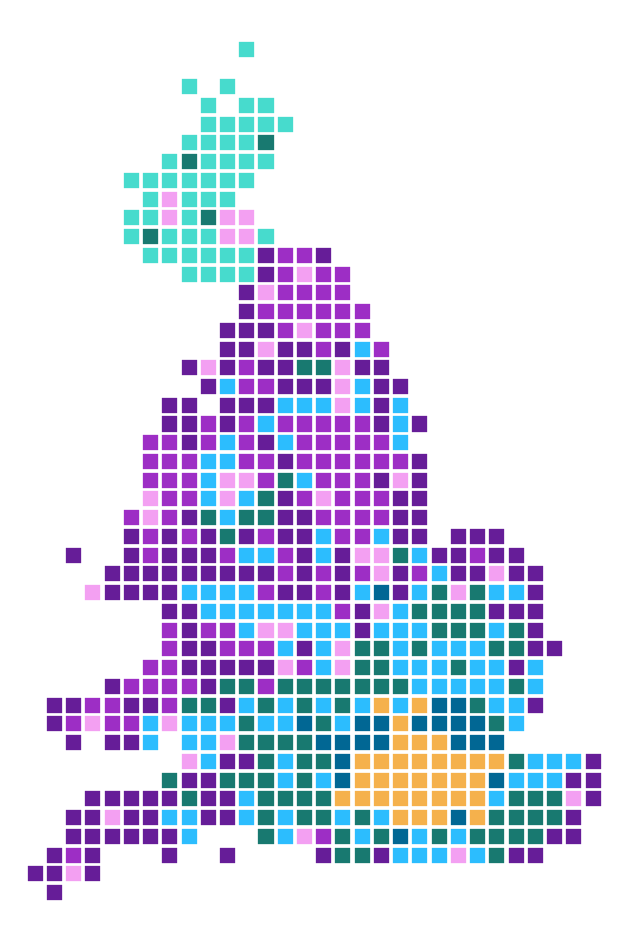

In [91]:
gb_cluster_yg['Colors'] = gb_cluster_yg['Cluster'].map(
    lambda x: color_list[x])

kpi_map('Population',
        colors=gb_cluster_yg[['Colors']],
        data=pd.read_csv('data_with_targets.csv').set_index('ID'),
        exc_color='#ffffff',
        exclude=['Northern Ireland'],
        width=11)

### DB Clustering

In [92]:
from sklearn.cluster import DBSCAN

#### UMAP

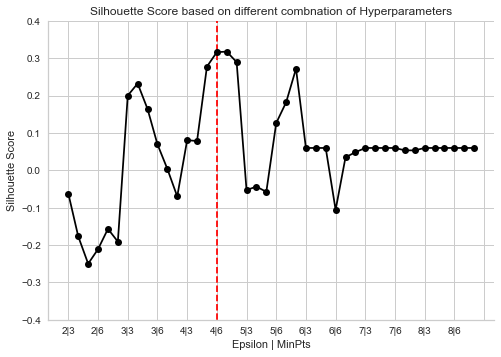

<Figure size 576x396 with 0 Axes>

In [93]:
from sklearn import metrics

# Create empty lists
S=[] # this is to store Silhouette scores
D = [] # Check davies bouldin score
H = [] # Check calinski harabasz

comb=[] # this is to store combinations of epsilon / min_samples

# Define ranges to explore
eps_range=range(2, 9)  # note, we will scale this down by 100 as we want to explore 0.06 - 0.11 range
minpts_range=range(3,9)

for k in eps_range:
    for j in minpts_range:
        # Set the model and its parameters
        model = DBSCAN(eps=k/10, min_samples=j)
        # Fit the model 
        clm = model.fit(umap_df)
        # Calculate Silhoutte, Davies Bouldin and Harabasz Score and append to a list
        S.append(metrics.silhouette_score(umap_df, clm.labels_, metric='euclidean'))
        D.append(metrics.davies_bouldin_score(umap_df, clm.labels_))
        H.append(metrics.calinski_harabasz_score(umap_df, clm.labels_))
        comb.append(str(k)+"|"+str(j)) # axis values for the graph


# Plot the resulting Silhouette scores on a graph
fig = plt.figure()
ax = plt.subplot(1, 1, 1)
plt.plot(comb, S, 'bo-', color='black')
from matplotlib.ticker import MaxNLocator

ax.xaxis.set_major_locator(MaxNLocator(16))

plt.xlabel('Epsilon | MinPts')
plt.ylabel('Silhouette Score')
plt.vlines(x=15, ymin=-0.6, ymax=0.75, color='red', linestyle='--')
plt.title('Silhouette Score based on different combnation of Hyperparameters')
plt.ylim(-0.4, 0.4)
plt.show()
plt.tight_layout()

In [94]:
# Silhouette Score --> Epsilon = 0.4, Minimum points = 6

In [424]:
# Calinski Harabasz Score for Mean Shift
bandwidths = range(2, 11)
e = range(2, 11)
score=[]
for b in bandwidths:
    for i in e:
        ms = MeanShift(bandwidth=b/10)
        model = ms.fit(umap_df)
        model_2 = model.predict(umap_df)
        score_d = calinski_harabasz_score(umap_df, model_2)
        score.append((b, score_d, i))
score_1 = pd.DataFrame(score)
score_1.columns = ['Bandwiths', 'Calinski_Harabasz_Score', 'E']
score_2 = score_1[score_1.Calinski_Harabasz_Score == score_1.Calinski_Harabasz_Score.max()]
score_2.head(n=2)

,Bandwiths,Calinski_Harabasz_Score,E
72,10,993.422909,2
73,10,993.422909,3


In [465]:
def DBScan_func(dim_red, metric):

    score = []
    # Define ranges to explore
    eps_range=range(3, 11)  
    minpts_range=range(3,11)
    
    for k in eps_range:
        for j in minpts_range:
            for x in ['auto', 'ball_tree', 'kd_tree', 'brute']:
            
                if dim_red == 'PCA':
                    model = DBSCAN(eps=k, min_samples=j, algorithm=x)
                    clm = model.fit(PCA_df_gb)
                    score_d = metrics.davies_bouldin_score(PCA_df_gb, clm.labels_)
                    score_s = metrics.silhouette_score(PCA_df_gb, clm.labels_, metric='euclidean')
                    score_h = metrics.calinski_harabasz_score(PCA_df_gb, clm.labels_)
                    score.append((k, j, score_d, score_s, score_h, x))

                elif dim_red == 'UMAP':
                    model = DBSCAN(eps=k/10, min_samples=j)
                    clm = model.fit(umap_df)
                    score_d = metrics.davies_bouldin_score(umap_df, clm.labels_)
                    score_s = metrics.silhouette_score(umap_df, clm.labels_, metric='euclidean')
                    score_h = metrics.calinski_harabasz_score(umap_df, clm.labels_)
                    score.append((k/10, j, score_d, score_s, score_h, x))
                
    score_1 = pd.DataFrame(score)
    score_1.columns = ['Epsilon', 'Minimum_points', 'Davies_Bouldin_Score', 'Silhouette_Score', 'Calinski_Harabasz', 'Algorithm']
    
    if metric == 'Davies Bouldin':
        score_2 = score_1[score_1.Davies_Bouldin_Score == score_1.Davies_Bouldin_Score.min()]
        
    elif metric == 'Silhouette':
        score_2 = score_1[score_1.Silhouette_Score == score_1.Silhouette_Score.max()] 
        
    elif metric == 'Calinski':
        score_2 = score_1[score_1.Calinski_Harabasz == score_1.Calinski_Harabasz.max()]
    
    return score_2.head(2)

In [469]:
DBScan_func('UMAP', 'Silhouette')

,Epsilon,Minimum_points,Davies_Bouldin_Score,Silhouette_Score,Calinski_Harabasz,Algorithm
192,0.9,3,0.45361,0.557702,318.232733,auto
193,0.9,3,0.45361,0.557702,318.232733,ball_tree


In [438]:
df[df.Davies_Bouldin_Score == df.Davies_Bouldin_Score.min()].head(2)

,Epsilon,Minimum_points,Davies_Bouldin_Score
48,9,3,0.194396
49,9,4,0.194396


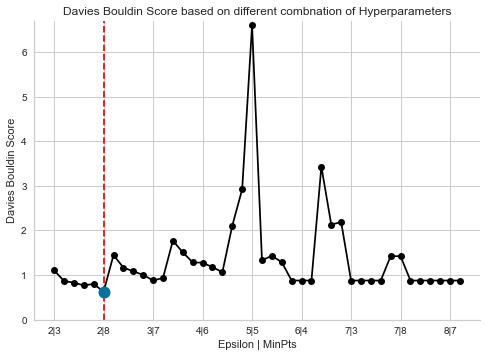

<Figure size 576x396 with 0 Axes>

In [95]:
fig = plt.figure()
ax = plt.subplot(1, 1, 1)
plt.plot(comb, D, 'bo-', color='black')
from matplotlib.ticker import MaxNLocator

ax.xaxis.set_major_locator(MaxNLocator(11))

plt.xlabel('Epsilon | MinPts')
plt.ylabel('Davies Bouldin Score')
plt.vlines(x=5, ymin=0, ymax=10, color='red', linestyle='--')
plt.plot(5, min(D), 'o', markersize=12)
plt.ylim(0, max(D)+0.1)
plt.title('Davies Bouldin Score based on different combnation of Hyperparameters')
plt.show()
plt.tight_layout()

In [96]:
min(D)

0.6283084373385205

In [97]:
# Davies Bouldin Score --> Epsilon = 0.2, Minimum Points = 8

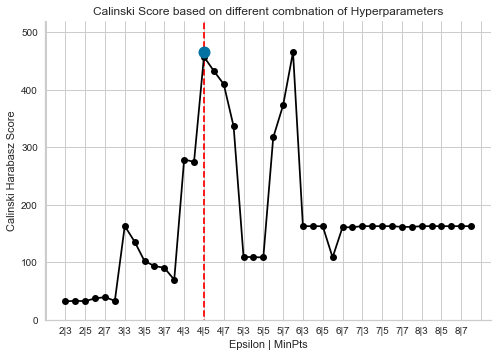

<Figure size 576x396 with 0 Axes>

In [98]:
fig = plt.figure()
ax = plt.subplot(1, 1, 1)
plt.plot(comb, H, 'bo-', color='black')
from matplotlib.ticker import MaxNLocator

ax.xaxis.set_major_locator(MaxNLocator(25))

plt.xlabel('Epsilon | MinPts')
plt.ylabel('Calinski Harabasz Score')
plt.vlines(x=14, ymin=-10, ymax=600, color='red', linestyle='--')
plt.plot(14, max(H), 'o', markersize=12)
plt.title('Calinski Score based on different combnation of Hyperparameters')
plt.ylim(0, 520)
plt.show()
plt.tight_layout()

In [99]:
# Calinski Score --> Epsilon = 0.4, Minimum Points = 5

In [ ]:
model46 = DBSCAN(eps=0.4, # default=0.5, 
               min_samples=6, # default=5, The number of samples (or total weight) in a neighborhood for a point to be considered as a core point.
               metric='euclidean', # default='euclidean'. The metric to use when calculating distance between instances in a feature array. 
               metric_params=None, # default=None, Additional keyword arguments for the metric function.
               algorithm='auto', # {‘auto’, ‘ball_tree’, ‘kd_tree’, ‘brute’}, default=’auto’, 
               p=None, # default=None, The power of the Minkowski metric to be used to calculate distance between points. 
               n_jobs=-1, # default=None, The number of parallel jobs to run.
              )

# Fit the models
clm46 = model46.fit(umap_df)
# Print DBSCAN results
print('*************** DBSCAN Clustering Model ***************')
print("Cluster labels for the first model")
print(np.unique(clm46.labels_))

preds = model28.fit_predict(umap_df)

In [100]:
# First model: eps=0.4, MinPts=6
model46 = DBSCAN(eps=0.4, # default=0.5, The maximum distance between two samples for one to be considered as in the neighborhood of the other.
               min_samples=6, # default=5, The number of samples (or total weight) in a neighborhood for a point to be considered as a core point.
               metric='euclidean', # default='euclidean'. The metric to use when calculating distance between instances in a feature array. 
               metric_params=None, # default=None, Additional keyword arguments for the metric function.
               algorithm='auto', # {‘auto’, ‘ball_tree’, ‘kd_tree’, ‘brute’}, default=’auto’, The algorithm to be used by the NearestNeighbors module to compute pointwise distances and find nearest neighbors.
               leaf_size=30, # default=30, Leaf size passed to BallTree or cKDTree.
               p=None, # default=None, The power of the Minkowski metric to be used to calculate distance between points. If None, then p=2
               n_jobs=-1, # default=None, The number of parallel jobs to run. None means 1 unless in a joblib.parallel_backend context. -1 means using all processors.
              )

# Fit the models
clm46 = model46.fit(umap_df)

# Print DBSCAN results
print('*************** DBSCAN Clustering Model ***************')
print("Cluster labels for the first model")
print(np.unique(clm46.labels_))

*************** DBSCAN Clustering Model ***************
Cluster labels for the first model
[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]


In [101]:
# Let us try the Davies Boudlin result to see if we get more clusters (-1 are outliers)
model28 = DBSCAN(eps=0.2, # default=0.5, The maximum distance between two samples for one to be considered as in the neighborhood of the other.
               min_samples=8, # default=5, The number of samples (or total weight) in a neighborhood for a point to be considered as a core point.
               metric='euclidean', # default='euclidean'. The metric to use when calculating distance between instances in a feature array. 
               metric_params=None, # default=None, Additional keyword arguments for the metric function.
               algorithm='auto', # {‘auto’, ‘ball_tree’, ‘kd_tree’, ‘brute’}, default=’auto’, The algorithm to be used by the NearestNeighbors module to compute pointwise distances and find nearest neighbors.
               leaf_size=30, # default=30, Leaf size passed to BallTree or cKDTree.
               p=None, # default=None, The power of the Minkowski metric to be used to calculate distance between points. If None, then p=2
               n_jobs=-1, # default=None, The number of parallel jobs to run. None means 1 unless in a joblib.parallel_backend context. -1 means using all processors.
              )

# Fit the models
clm28 = model28.fit(umap_df)

# Print DBSCAN results
print('*************** DBSCAN Clustering Model ***************')
print("Cluster labels for the first model")
print(np.unique(clm28.labels_))


preds = model28.fit_predict(umap_df)

*************** DBSCAN Clustering Model ***************
Cluster labels for the first model
[-1  0  1  2  3  4  5]


In [102]:
# Lastly we try Calinski Harabasz
# First model: eps=0.4, MinPts=5
model45 = DBSCAN(eps=0.4, # default=0.5, The maximum distance between two samples for one to be considered as in the neighborhood of the other.
               min_samples=5, # default=5, The number of samples (or total weight) in a neighborhood for a point to be considered as a core point.
               metric='euclidean', # default='euclidean'. The metric to use when calculating distance between instances in a feature array. 
               metric_params=None, # default=None, Additional keyword arguments for the metric function.
               algorithm='auto', # {‘auto’, ‘ball_tree’, ‘kd_tree’, ‘brute’}, default=’auto’, The algorithm to be used by the NearestNeighbors module to compute pointwise distances and find nearest neighbors.
               leaf_size=30, # default=30, Leaf size passed to BallTree or cKDTree.
               p=None, # default=None, The power of the Minkowski metric to be used to calculate distance between points. If None, then p=2
               n_jobs=-1, # default=None, The number of parallel jobs to run. None means 1 unless in a joblib.parallel_backend context. -1 means using all processors.
              )

# Fit the models
clm45 = model45.fit(umap_df)

# Print DBSCAN results
print('*************** DBSCAN Clustering Model ***************')
print("Cluster labels for the first model")
print(np.unique(clm45.labels_))

*************** DBSCAN Clustering Model ***************
Cluster labels for the first model
[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


In [103]:
# Out of all, focusing on the Davies Boudlin Index would be best as the cluster number are appropriate for further inspection

In [104]:
preds = model28.fit_predict(umap_df)

db_preds_gb = []
#Store the predicted labels
db_preds_gb.append(preds)

gb_cluster_yg = pd.concat([y19_st_gb,
                           pd.DataFrame(db_preds_gb[0], 
                                        index=y17_st_gb.index,
                                        columns=['Cluster'])],
                           axis=1)

gb_cluster_yg_pivot = pd.pivot_table(data = gb_cluster_yg,
                                     index='seat_types_yg',
                                     columns='Cluster',
                                     aggfunc=len,
                                     fill_value=0)

gb_cluster_yg_pivot

Cluster,-1,0,1,2,3,4,5
seat_types_yg,,,,,,,
con lab marginal,144,0,2,0,0,0,1
con ld marginal,19,0,2,1,0,0,0
con pc marginal,1,0,0,0,0,0,0
con safe,253,0,0,6,0,0,0
con snp marginal,15,0,0,0,0,5,0
green safe,1,0,0,0,0,0,0
lab ld marginal,1,0,0,0,0,0,0
lab safe,113,10,4,0,0,0,8
lab snp marginal,5,0,0,0,5,0,0


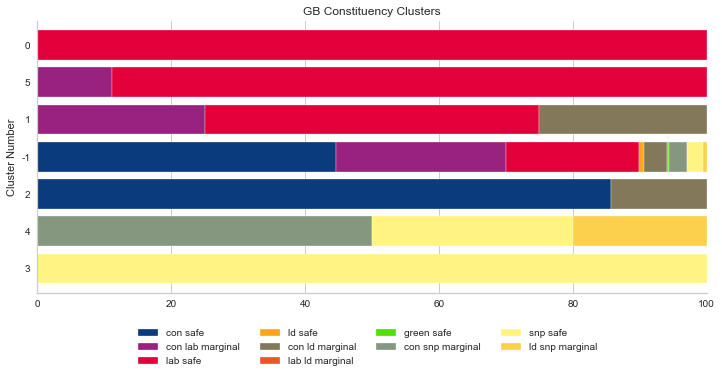

In [105]:
gb_cluster_yg_pivot=gb_cluster_yg_pivot.reindex(party_list)

gb_cluster_bar = (gb_cluster_yg_pivot / gb_cluster_yg_pivot.sum()).T.sort_values(by=['lab safe', 'con safe'], ascending=True)

gb_cluster_bar.plot.barh(stacked=True,
                          figsize=(12,5),
                          width=0.8,
                          color=party_colors)

plt.xticks(ticks = np.arange(0,1.2,0.2), labels = np.arange(0,120,20))
plt.xlim(0,1);

plt.title('GB Constituency Clusters');
plt.ylabel('Cluster Number')

plt.legend(bbox_to_anchor=(0.85, -0.1),
           ncol=4,
           frameon=False);

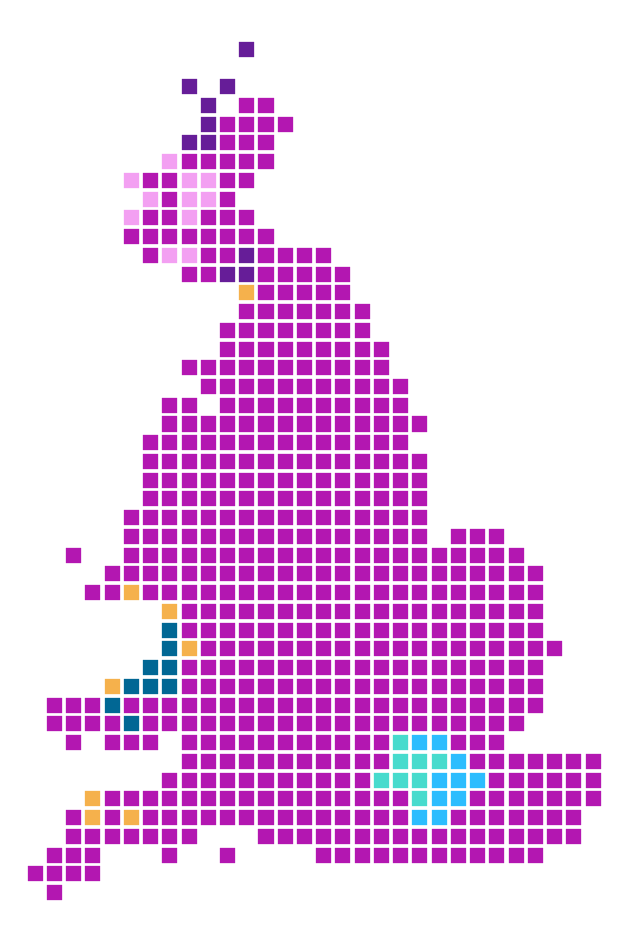

In [106]:
gb_cluster_yg['Colors'] = gb_cluster_yg['Cluster'].map(
    lambda x: color_list[x])

kpi_map('Population',
        colors=gb_cluster_yg[['Colors']],
        data=pd.read_csv('data_with_targets.csv').set_index('ID'),
        exc_color='#ffffff',
        exclude=['Northern Ireland'],
        width=11)

#### PCA

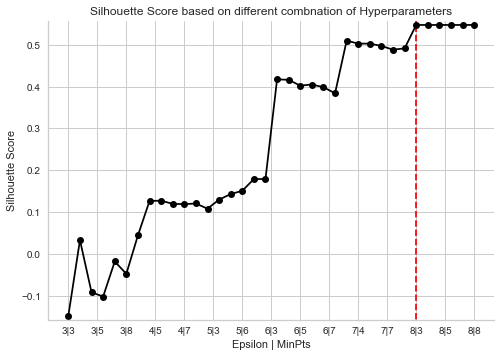

<Figure size 576x396 with 0 Axes>

In [107]:
from sklearn import metrics

# Create empty lists
S=[] # this is to store Silhouette scores
D = [] # Check davies bouldin score
H = [] # Check calinski harabasz

comb=[] # this is to store combinations of epsilon / min_samples

# Define ranges to explore
eps_range=range(3, 9)  # note, we will scale this down by 100 as we want to explore 0.06 - 0.11 range
minpts_range=range(3,9)

for k in eps_range:
    for j in minpts_range:
        # Set the model and its parameters
        model = DBSCAN(eps=k, min_samples=j)
        # Fit the model 
        clm = model.fit(PCA_df_gb)
        # Calculate Silhoutte, Davies Bouldin and Harabasz Score and append to a list
        S.append(metrics.silhouette_score(PCA_df_gb, clm.labels_, metric='euclidean'))
        D.append(metrics.davies_bouldin_score(PCA_df_gb, clm.labels_))
        H.append(metrics.calinski_harabasz_score(PCA_df_gb, clm.labels_))
        comb.append(str(k)+"|"+str(j)) # axis values for the graph


# Plot the resulting Silhouette scores on a graph
fig = plt.figure()
ax = plt.subplot(1, 1, 1)
plt.plot(comb, S, 'bo-', color='black')
from matplotlib.ticker import MaxNLocator

ax.xaxis.set_major_locator(MaxNLocator(16))

plt.xlabel('Epsilon | MinPts')
plt.ylabel('Silhouette Score')
plt.vlines(x=30, ymin=-0.6, ymax=0.75, color='red', linestyle='--')
plt.title('Silhouette Score based on different combnation of Hyperparameters')
plt.ylim(min(S) - 0.01, max(S) + 0.01)
plt.show()
plt.tight_layout()

In [108]:
# Silhouette Score --> epsilon = 8, min_points = 3

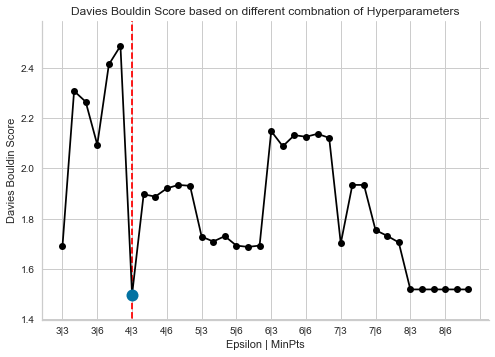

<Figure size 576x396 with 0 Axes>

In [109]:
fig = plt.figure()
ax = plt.subplot(1, 1, 1)
plt.plot(comb, D, 'bo-', color='black')
from matplotlib.ticker import MaxNLocator

ax.xaxis.set_major_locator(MaxNLocator(13))

plt.xlabel('Epsilon | MinPts')
plt.ylabel('Davies Bouldin Score')
plt.vlines(x=6, ymin=0, ymax=10, color='red', linestyle='--')
plt.plot(6, min(D), 'o', markersize=12)
plt.ylim(min(D)-0.1, max(D)+0.1)
plt.title('Davies Bouldin Score based on different combnation of Hyperparameters')
plt.show()
plt.tight_layout()

In [110]:
# Davies Bouldin Index --> epsilon = 4, minimum_points=3

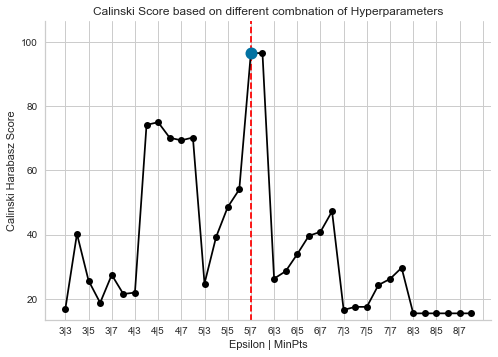

<Figure size 576x396 with 0 Axes>

In [111]:
fig = plt.figure()
ax = plt.subplot(1, 1, 1)
plt.plot(comb, H, 'bo-', color='black')
from matplotlib.ticker import MaxNLocator

ax.xaxis.set_major_locator(MaxNLocator(25))

plt.xlabel('Epsilon | MinPts')
plt.ylabel('Calinski Harabasz Score')
plt.vlines(x=16, ymin=-10, ymax=600, color='red', linestyle='--')
plt.plot(16, max(H), 'o', markersize=12)
plt.title('Calinski Score based on different combnation of Hyperparameters')
plt.ylim(min(H) - 2, max(H) + 10)
plt.show()
plt.tight_layout()

In [112]:
# Calinski Score --> epsilon = 5, minimum_points=7

#### Clustering Analysis

In [113]:
# First model: eps=8, MinPts=3
model83 = DBSCAN(eps=8, # default=0.5, The maximum distance between two samples for one to be considered as in the neighborhood of the other.
               min_samples=3, # default=5, The number of samples (or total weight) in a neighborhood for a point to be considered as a core point.
               metric='euclidean', # default='euclidean'. The metric to use when calculating distance between instances in a feature array. 
               metric_params=None, # default=None, Additional keyword arguments for the metric function.
               algorithm='auto', # {‘auto’, ‘ball_tree’, ‘kd_tree’, ‘brute’}, default=’auto’, The algorithm to be used by the NearestNeighbors module to compute pointwise distances and find nearest neighbors.
               leaf_size=30, # default=30, Leaf size passed to BallTree or cKDTree.
               p=None, # default=None, The power of the Minkowski metric to be used to calculate distance between points. If None, then p=2
               n_jobs=-1, # default=None, The number of parallel jobs to run. None means 1 unless in a joblib.parallel_backend context. -1 means using all processors.
              )

# Fit the models
clm83 = model83.fit(PCA_df_gb)

# Print DBSCAN results
print('*************** DBSCAN Clustering Model ***************')
print("Cluster labels for the first model")
print(np.unique(clm83.labels_))

*************** DBSCAN Clustering Model ***************
Cluster labels for the first model
[-1  0]


In [114]:
# Let us try the Davies Boudlin result to see if we get more clusters (-1 are outliers)
model43 = DBSCAN(eps=4, # default=0.5, The maximum distance between two samples for one to be considered as in the neighborhood of the other.
               min_samples=3, # default=5, The number of samples (or total weight) in a neighborhood for a point to be considered as a core point.
               metric='euclidean', # default='euclidean'. The metric to use when calculating distance between instances in a feature array. 
               metric_params=None, # default=None, Additional keyword arguments for the metric function.
               algorithm='auto', # {‘auto’, ‘ball_tree’, ‘kd_tree’, ‘brute’}, default=’auto’, The algorithm to be used by the NearestNeighbors module to compute pointwise distances and find nearest neighbors.
               leaf_size=30, # default=30, Leaf size passed to BallTree or cKDTree.
               p=None, # default=None, The power of the Minkowski metric to be used to calculate distance between points. If None, then p=2
               n_jobs=-1, # default=None, The number of parallel jobs to run. None means 1 unless in a joblib.parallel_backend context. -1 means using all processors.
              )

# Fit the models
clm43 = model43.fit(PCA_df_gb)

# Print DBSCAN results
print('*************** DBSCAN Clustering Model ***************')
print("Cluster labels for the first model")
print(np.unique(clm43.labels_))

*************** DBSCAN Clustering Model ***************
Cluster labels for the first model
[-1  0  1  2  3  4  5  6  7  8  9]


In [115]:
# Lastly we try Calinski Harabasz
# First model: eps=5, MinPts=7
model57 = DBSCAN(eps=5, # default=0.5, The maximum distance between two samples for one to be considered as in the neighborhood of the other.
               min_samples=7, # default=5, The number of samples (or total weight) in a neighborhood for a point to be considered as a core point.
               metric='euclidean', # default='euclidean'. The metric to use when calculating distance between instances in a feature array. 
               metric_params=None, # default=None, Additional keyword arguments for the metric function.
               algorithm='auto', # {‘auto’, ‘ball_tree’, ‘kd_tree’, ‘brute’}, default=’auto’, The algorithm to be used by the NearestNeighbors module to compute pointwise distances and find nearest neighbors.
               leaf_size=30, # default=30, Leaf size passed to BallTree or cKDTree.
               p=None, # default=None, The power of the Minkowski metric to be used to calculate distance between points. If None, then p=2
               n_jobs=-1, # default=None, The number of parallel jobs to run. None means 1 unless in a joblib.parallel_backend context. -1 means using all processors.
              )

# Fit the models
clm57 = model57.fit(PCA_df_gb)

# Print DBSCAN results
print('*************** DBSCAN Clustering Model ***************')
print("Cluster labels for the first model")
print(np.unique(clm57.labels_))

*************** DBSCAN Clustering Model ***************
Cluster labels for the first model
[-1  0  1]


In [116]:
# Again with Davies Bouldin, we get the most suitable number of clusters and we will go with that

In [117]:
preds = model83.fit_predict(PCA_df_gb)

db_preds_gb = []
#Store the predicted labels
db_preds_gb.append(preds)

gb_cluster_yg = pd.concat([y19_st_gb,
                           pd.DataFrame(db_preds_gb[0], 
                                        index=y17_st_gb.index,
                                        columns=['Cluster'])],
                           axis=1)

gb_cluster_yg_pivot = pd.pivot_table(data = gb_cluster_yg,
                                     index='seat_types_yg',
                                     columns='Cluster',
                                     aggfunc=len,
                                     fill_value=0)

gb_cluster_yg_pivot

Cluster,-1,0
seat_types_yg,,
con lab marginal,1,146
con ld marginal,0,22
con pc marginal,0,1
con safe,0,259
con snp marginal,0,20
green safe,0,1
lab ld marginal,0,1
lab safe,2,133
lab snp marginal,0,10


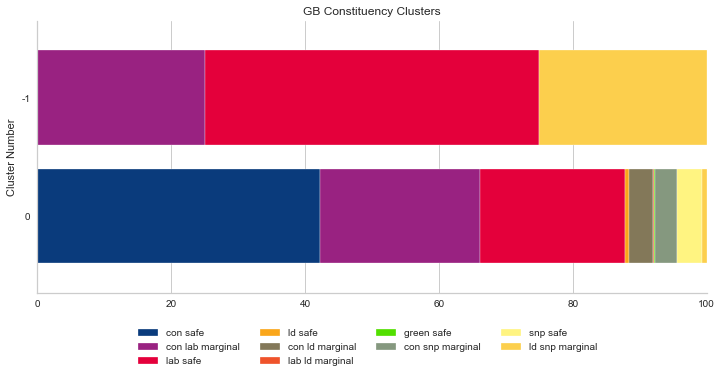

In [118]:
gb_cluster_yg_pivot=gb_cluster_yg_pivot.reindex(party_list)

gb_cluster_bar = (gb_cluster_yg_pivot / gb_cluster_yg_pivot.sum()).T.sort_values(by=['lab safe', 'con safe',
                                                                                    'snp safe'], ascending=True)

gb_cluster_bar.plot.barh(stacked=True,
                          figsize=(12,5),
                          width=0.8,
                          color=party_colors)

plt.xticks(ticks = np.arange(0,1.2,0.2), labels = np.arange(0,120,20))
plt.xlim(0,1);

plt.title('GB Constituency Clusters');
plt.ylabel('Cluster Number')

plt.legend(bbox_to_anchor=(0.85, -0.1),
           ncol=4,
           frameon=False);

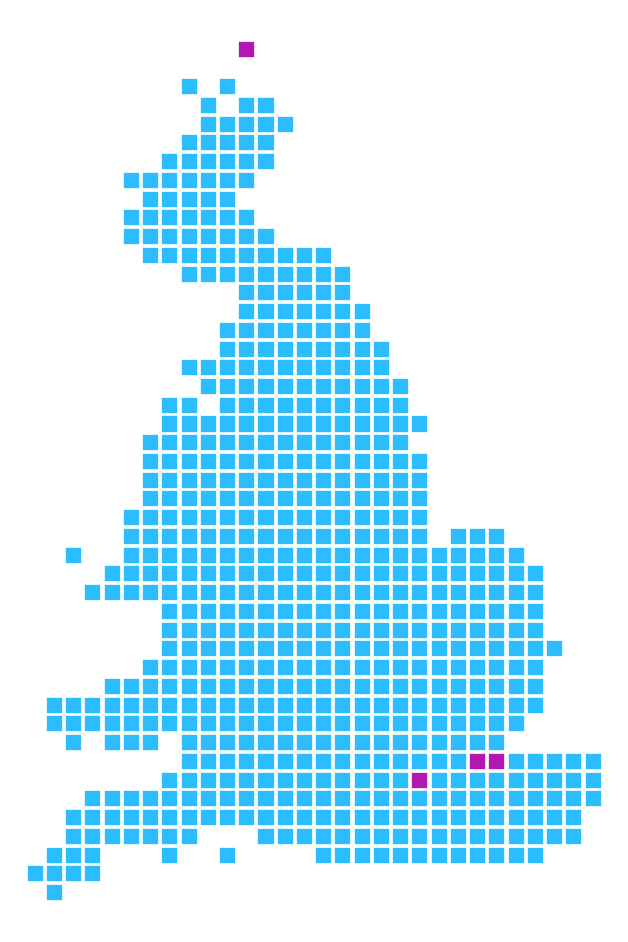

In [119]:
gb_cluster_yg['Colors'] = gb_cluster_yg['Cluster'].map(
    lambda x: color_list[x])

kpi_map('Population',
        colors=gb_cluster_yg[['Colors']],
        data=pd.read_csv('data_with_targets.csv').set_index('ID'),
        exc_color='#ffffff',
        exclude=['Northern Ireland'],
        width=11)

6.672812431182526


<Figure size 360x360 with 0 Axes>

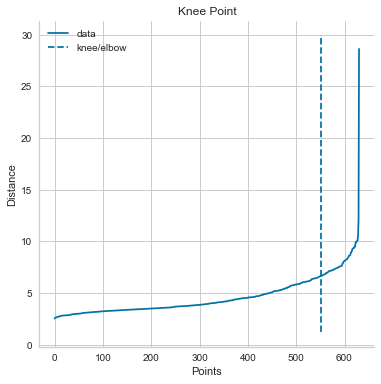

In [120]:
from sklearn.neighbors import NearestNeighbors
nearest_neighbors = NearestNeighbors(n_neighbors=11)
neighbors = nearest_neighbors.fit(PCA_df_gb)
distances, indices = neighbors.kneighbors(PCA_df_gb)
distances = np.sort(distances[:,10], axis=0)

from kneed import KneeLocator
i = np.arange(len(distances))
knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')
fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")

print(distances[knee.knee])

### Mean Shift

#### UMAP

In [121]:
from sklearn.cluster import MeanShift

In [122]:
# Calinski Harabasz Score for Mean Shift
bandwidths = range(2, 11)
score=[]
for b in bandwidths:
        ms = MeanShift(bandwidth=b/10)
        model = ms.fit(umap_df)
        model_2 = model.predict(umap_df)
        score_d = calinski_harabasz_score(umap_df, model_2)
        score.append((b, score_d))
score_1 = pd.DataFrame(score)
score_1.columns = ['Bandwiths', 'Calinski_Harabasz_Score']
score_2 = score_1[score_1.Calinski_Harabasz_Score == score_1.Calinski_Harabasz_Score.max()]
score_2.head(n=2)

,Bandwiths,Calinski_Harabasz_Score
8,10,993.422909


In [123]:
# Silhouette Score for Mean Shift


bandwidths = range(2, 11)
score=[]
for b in bandwidths:
        ms = MeanShift(bandwidth=b/10)
        model = ms.fit(umap_df)
        model_2 = model.predict(umap_df)
        score_d = silhouette_score(umap_df, model_2, metric='euclidean')
        score.append((b, score_d))
score_1 = pd.DataFrame(score)
score_1.columns = ['Bandwiths', 'Silhouette_Score']
score_2 = score_1[score_1.Silhouette_Score == score_1.Silhouette_Score.max()]
score_2.head(n=2)

,Bandwiths,Silhouette_Score
8,10,0.452139


In [124]:
# Davies Bouldin Score for Mean Shift


bandwidths = range(2, 11)
score=[]
for b in bandwidths:
        ms = MeanShift(bandwidth=b/10)
        model = ms.fit(umap_df)
        model_2 = model.predict(umap_df)
        score_d = davies_bouldin_score(umap_df, model_2)
        score.append((b, score_d))
score_1 = pd.DataFrame(score)
score_1.columns = ['Bandwiths', 'Davies_Bouldin_Score']
score_2 = score_1[score_1.Davies_Bouldin_Score == score_1.Davies_Bouldin_Score.min()]
score_2.head(n=2)

,Bandwiths,Davies_Bouldin_Score
0,2,0.398087


In [125]:
ms = MeanShift(bandwidth=1) # Majority is 10/10 = 1
ms.fit(umap_df)

yhat = ms.predict(umap_df)
# retrieve unique clusters
clusters = np.unique(yhat)


db_preds_gb = []
#Store the predicted labels
db_preds_gb.append(yhat)


gb_cluster_yg = pd.concat([y19_st_gb,
                           pd.DataFrame(db_preds_gb[0], 
                                        index=y17_st_gb.index,
                                        columns=['Cluster'])],
                           axis=1)

gb_cluster_yg_pivot = pd.pivot_table(data = gb_cluster_yg,
                                     index='seat_types_yg',
                                     columns='Cluster',
                                     aggfunc=len,
                                     fill_value=0)

gb_cluster_yg_pivot

Cluster,0,1,2,3,4,5,6,7,8,9
seat_types_yg,,,,,,,,,,
con lab marginal,8,14,55,0,15,17,14,24,0,0
con ld marginal,6,2,0,4,3,0,0,0,0,7
con pc marginal,1,0,0,0,0,0,0,0,0,0
con safe,58,49,34,39,1,1,42,2,0,33
con snp marginal,0,1,0,0,0,0,0,0,19,0
green safe,0,0,0,0,0,1,0,0,0,0
lab ld marginal,0,0,0,1,0,0,0,0,0,0
lab safe,0,1,34,0,42,35,0,23,0,0
lab snp marginal,0,0,0,0,0,0,0,0,10,0


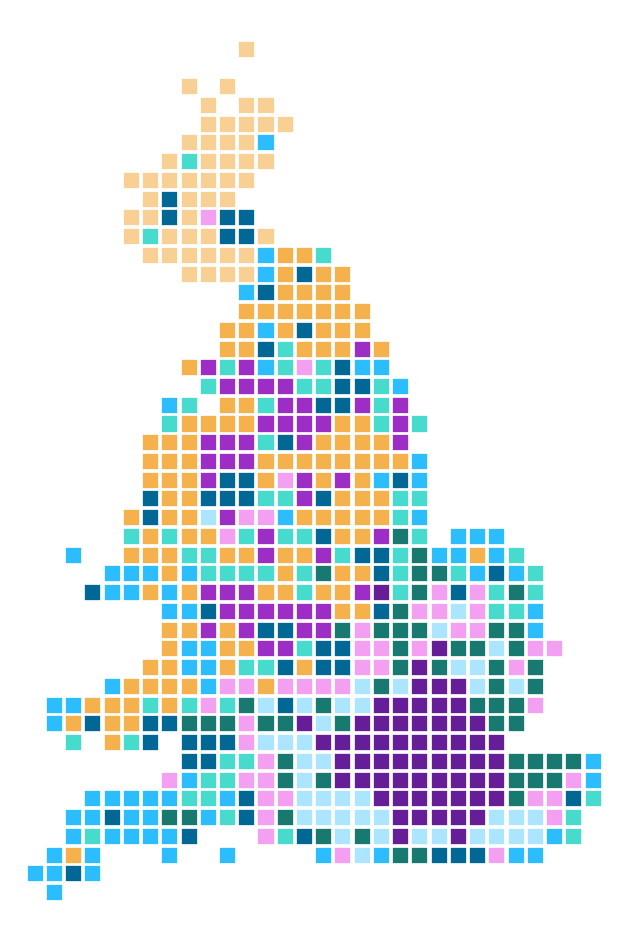

In [126]:
gb_cluster_yg['Colors'] = gb_cluster_yg['Cluster'].map(
    lambda x: color_list[x])

kpi_map('Population',
        colors=gb_cluster_yg[['Colors']],
        data=pd.read_csv('data_with_targets.csv').set_index('ID'),
        exc_color='#ffffff',
        exclude=['Northern Ireland'],
        width=11)

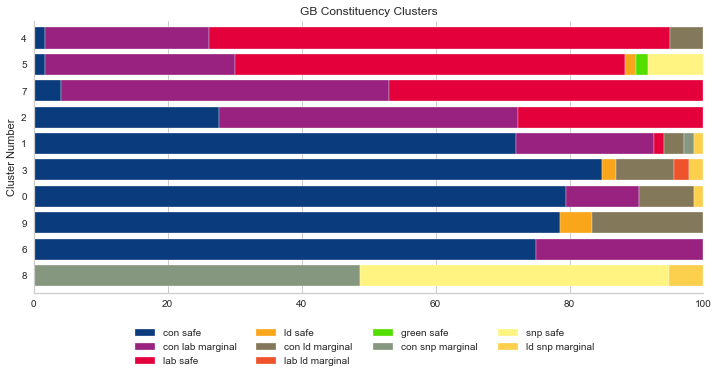

In [127]:
gb_cluster_yg_pivot=gb_cluster_yg_pivot.reindex(party_list)

gb_cluster_bar = (gb_cluster_yg_pivot / gb_cluster_yg_pivot.sum()).T.sort_values(by=['lab safe', 'con safe',
                                                                                    'snp safe'], ascending=True)

gb_cluster_bar.plot.barh(stacked=True,
                          figsize=(12,5),
                          width=0.8,
                          color=party_colors)

plt.xticks(ticks = np.arange(0,1.2,0.2), labels = np.arange(0,120,20))
plt.xlim(0,1);

plt.title('GB Constituency Clusters');
plt.ylabel('Cluster Number')

plt.legend(bbox_to_anchor=(0.85, -0.1),
           ncol=4,
           frameon=False);

#### PCA

In [128]:
# Calinski Harabasz Score for Mean Shift
bandwidths = range(2, 11)
score=[]
for b in bandwidths:
        ms = MeanShift(bandwidth=b)
        model = ms.fit(PCA_df_gb)
        model_2 = model.predict(PCA_df_gb)
        score_d = calinski_harabasz_score(PCA_df_gb, model_2)
        score.append((b, score_d))
score_1 = pd.DataFrame(score)
score_1.columns = ['Bandwiths', 'Calinski_Harabasz_Score']
score_2 = score_1[score_1.Calinski_Harabasz_Score == score_1.Calinski_Harabasz_Score.max()]
score_2.head(n=2)

,Bandwiths,Calinski_Harabasz_Score
6,8,67.716874


In [129]:
# Silhouette Score for Mean Shift


bandwidths = range(2, 11)
score=[]
for b in bandwidths:
        ms = MeanShift(bandwidth=b)
        model = ms.fit(PCA_df_gb)
        model_2 = model.predict(PCA_df_gb)
        score_d = silhouette_score(PCA_df_gb, model_2, metric='euclidean')
        score.append((b, score_d))
score_1 = pd.DataFrame(score)
score_1.columns = ['Bandwiths', 'Silhouette_Score']
score_2 = score_1[score_1.Silhouette_Score == score_1.Silhouette_Score.max()]
score_2.head(n=2)

,Bandwiths,Silhouette_Score
7,9,0.723218
8,10,0.723218


In [130]:
# Davies Bouldin Score for Mean Shift


bandwidths = range(2, 11)
score=[]
for b in bandwidths:
        ms = MeanShift(bandwidth=b)
        model = ms.fit(PCA_df_gb)
        model_2 = model.predict(PCA_df_gb)
        score_d = davies_bouldin_score(PCA_df_gb, model_2)
        score.append((b, score_d))
score_1 = pd.DataFrame(score)
score_1.columns = ['Bandwiths', 'Davies_Bouldin_Score']
score_2 = score_1[score_1.Davies_Bouldin_Score == score_1.Davies_Bouldin_Score.min()]
score_2.head(n=2)

,Bandwiths,Davies_Bouldin_Score
7,9,0.194398
8,10,0.194398


In [131]:
ms = MeanShift(bandwidth=8) # Majority is 9 & 10 but we will go with 8 of Calinski as it gives us 5 clusters
ms.fit(PCA_df_gb)

yhat = ms.predict(PCA_df_gb)
# retrieve unique clusters
clusters = np.unique(yhat)


db_preds_gb = []
#Store the predicted labels
db_preds_gb.append(yhat)


gb_cluster_yg = pd.concat([y19_st_gb,
                           pd.DataFrame(db_preds_gb[0], 
                                        index=y17_st_gb.index,
                                        columns=['Cluster'])],
                           axis=1)

gb_cluster_yg_pivot = pd.pivot_table(data = gb_cluster_yg,
                                     index='seat_types_yg',
                                     columns='Cluster',
                                     aggfunc=len,
                                     fill_value=0)

gb_cluster_yg_pivot

Cluster,0,1,2,3,4
seat_types_yg,,,,,
con lab marginal,137,9,0,1,0
con ld marginal,17,4,0,0,1
con pc marginal,1,0,0,0,0
con safe,258,1,0,0,0
con snp marginal,15,0,0,0,5
green safe,0,1,0,0,0
lab ld marginal,1,0,0,0,0
lab safe,87,39,9,0,0
lab snp marginal,10,0,0,0,0


#### Clustering Analysis

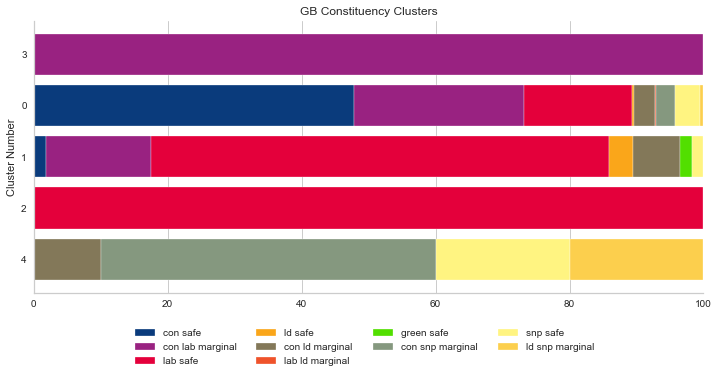

In [132]:
gb_cluster_yg_pivot=gb_cluster_yg_pivot.reindex(party_list)

gb_cluster_bar = (gb_cluster_yg_pivot / gb_cluster_yg_pivot.sum()).T.sort_values(by=['con lab marginal', 'lab safe'], 
                                                                                 ascending=True)

gb_cluster_bar.plot.barh(stacked=True,
                          figsize=(12,5),
                          width=0.8,
                          color=party_colors)

plt.xticks(ticks = np.arange(0,1.2,0.2), labels = np.arange(0,120,20))
plt.xlim(0,1);

plt.title('GB Constituency Clusters');
plt.ylabel('Cluster Number')

plt.legend(bbox_to_anchor=(0.85, -0.1),
           ncol=4,
           frameon=False);

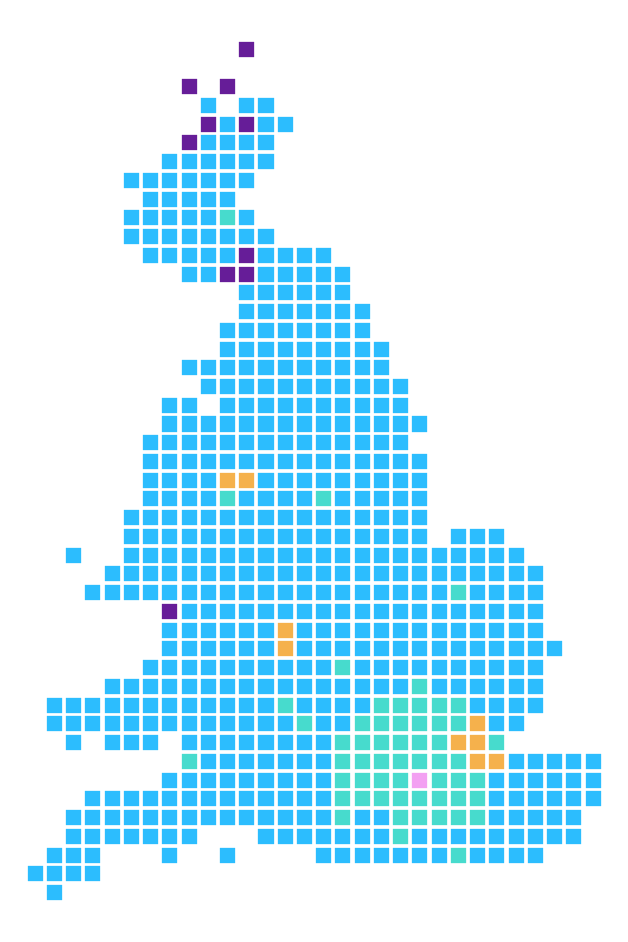

In [133]:
gb_cluster_yg['Colors'] = gb_cluster_yg['Cluster'].map(
    lambda x: color_list[x])

kpi_map('Population',
        colors=gb_cluster_yg[['Colors']],
        data=pd.read_csv('data_with_targets.csv').set_index('ID'),
        exc_color='#ffffff',
        exclude=['Northern Ireland'],
        width=11)

In [134]:
# Interesting as how central london constituency is its own cluster 

### Gaussian Mixture Modelling

#### UMAP

In [135]:
# BIC for GMM
### Using Bayesian information criterion score for Gaussian Mixture Modelling 
from sklearn.mixture import GaussianMixture
n_components = range(1, 30)
covariance_type = ['spherical', 'tied', 'diag', 'full']
score=[]
for cov in covariance_type:
    for n_comp in n_components:
        gmm=GaussianMixture(n_components=n_comp,covariance_type=cov, random_state = 10)
        gmm.fit(umap_df)
        score.append((cov,n_comp,gmm.bic(umap_df)))
score_1 = pd.DataFrame(score)
score_1.columns = ['Covariance_Type', 'N_Components','BIC_Score']
score_2 = score_1[score_1.BIC_Score == score_1.BIC_Score.min()]

score_2.head(n=2)

,Covariance_Type,N_Components,BIC_Score
95,full,9,-93646.078917


In [136]:
# Calinski Harabasz Score for GMM


n_components = range(2, 30)
covariance_type = ['spherical', 'tied', 'diag', 'full']
score=[]
for cov in covariance_type:
    for n_comp in n_components:
        gmm=GaussianMixture(n_components=n_comp,covariance_type=cov, random_state = 10)
        model = gmm.fit(umap_df)
        model_2 = model.predict(umap_df)
        score_c = calinski_harabasz_score(umap_df, model_2)
        score.append((cov,n_comp,score_c))
score_1 = pd.DataFrame(score)
score_1.columns = ['Covariance_Type', 'N_Components','Calinski_Harabasz_Score']
score_2 = score_1[score_1.Calinski_Harabasz_Score == score_1.Calinski_Harabasz_Score.max()]
score_2.head(n=5)

,Covariance_Type,N_Components,Calinski_Harabasz_Score
7,spherical,9,1013.614746


In [137]:
# Silhouette Score for GMM


n_components = range(2, 30)
covariance_type = ['spherical', 'tied', 'diag', 'full']
score=[]
for cov in covariance_type:
    for n_comp in n_components:
        gmm=GaussianMixture(n_components=n_comp,covariance_type=cov, random_state = 10)
        model = gmm.fit(umap_df)
        model_2 = model.predict(umap_df)
        score_c = silhouette_score(umap_df, model_2)
        score.append((cov,n_comp,score_c))
score_1 = pd.DataFrame(score)
score_1.columns = ['Covariance_Type', 'N_Components','Silhouette_Score']
score_2 = score_1[score_1.Silhouette_Score == score_1.Silhouette_Score.max()]
score_2.head(n=5)

,Covariance_Type,N_Components,Silhouette_Score
2,spherical,4,0.484057


In [138]:
# Davies Bouldin Score for GMM


n_components = range(2, 30)
covariance_type = ['spherical', 'tied', 'diag', 'full']
score=[]
for cov in covariance_type:
    for n_comp in n_components:
        gmm=GaussianMixture(n_components=n_comp,covariance_type=cov, random_state = 10)
        model = gmm.fit(umap_df)
        model_2 = model.predict(umap_df)
        score_c = davies_bouldin_score(umap_df, model_2)
        score.append((cov,n_comp,score_c))
score_1 = pd.DataFrame(score)
score_1.columns = ['Covariance_Type', 'N_Components','Davies_Bouldin']
score_2 = score_1[score_1.Davies_Bouldin == score_1.Davies_Bouldin.min()]
score_2.head(n=5)

,Covariance_Type,N_Components,Davies_Bouldin
2,spherical,4,0.657522


In [139]:
# Majority is spherical covariance and 4 components
# gaussian mixture clustering
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.mixture import GaussianMixture
from matplotlib import pyplot
# define the model
model = GaussianMixture(n_components= 4,covariance_type= "spherical", random_state = 10)
# fit the model
model.fit(umap_df)
# assign a cluster to each example
yhat = model.predict(umap_df)
# retrieve unique clusters
clusters = unique(yhat)

In [140]:
db_preds_gb = []
#Store the predicted labels
db_preds_gb.append(yhat)


gb_cluster_yg = pd.concat([y19_st_gb,
                           pd.DataFrame(db_preds_gb[0], 
                                        index=y17_st_gb.index,
                                        columns=['Cluster'])],
                           axis=1)

gb_cluster_yg_pivot = pd.pivot_table(data = gb_cluster_yg,
                                     index='seat_types_yg',
                                     columns='Cluster',
                                     aggfunc=len,
                                     fill_value=0)

gb_cluster_yg_pivot

Cluster,0,1,2,3
seat_types_yg,,,,
con lab marginal,23,103,0,21
con ld marginal,10,0,0,12
con pc marginal,0,0,0,1
con safe,54,61,0,144
con snp marginal,0,0,19,1
green safe,0,1,0,0
lab ld marginal,0,0,0,1
lab safe,42,92,0,1
lab snp marginal,0,0,10,0


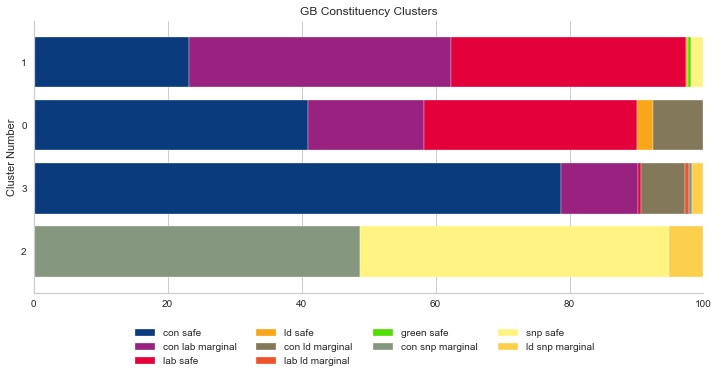

In [141]:
gb_cluster_yg_pivot=gb_cluster_yg_pivot.reindex(party_list)

gb_cluster_bar = (gb_cluster_yg_pivot / gb_cluster_yg_pivot.sum()).T.sort_values(by=['con lab marginal', 'lab safe'], 
                                                                                 ascending=True)

gb_cluster_bar.plot.barh(stacked=True,
                          figsize=(12,5),
                          width=0.8,
                          color=party_colors)

plt.xticks(ticks = np.arange(0,1.2,0.2), labels = np.arange(0,120,20))
plt.xlim(0,1);

plt.title('GB Constituency Clusters');
plt.ylabel('Cluster Number')

plt.legend(bbox_to_anchor=(0.85, -0.1),
           ncol=4,
           frameon=False);

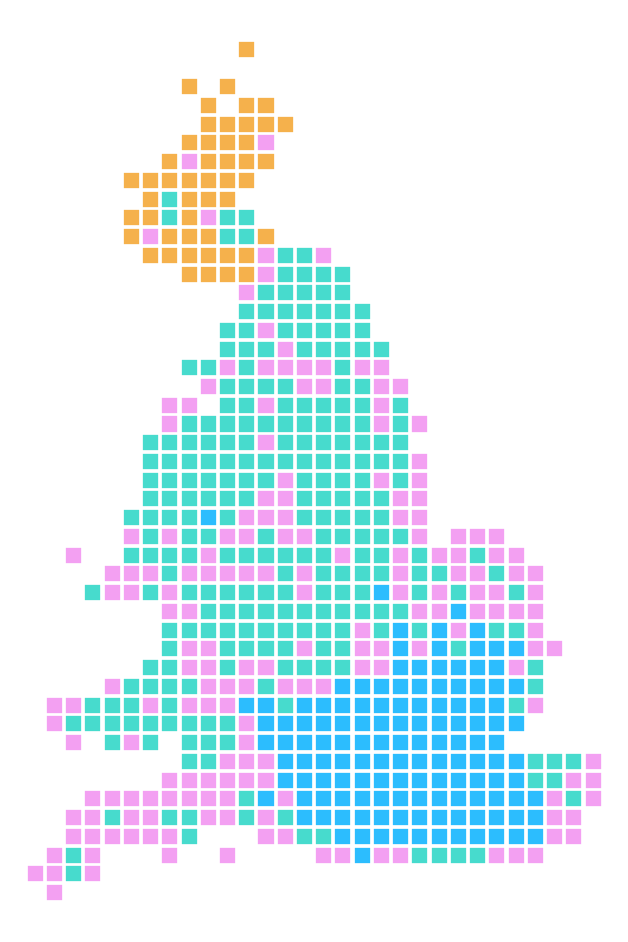

In [142]:
gb_cluster_yg['Colors'] = gb_cluster_yg['Cluster'].map(
    lambda x: color_list[x])

kpi_map('Population',
        colors=gb_cluster_yg[['Colors']],
        data=pd.read_csv('data_with_targets.csv').set_index('ID'),
        exc_color='#ffffff',
        exclude=['Northern Ireland'],
        width=11)

In [143]:
# Let us try Calinski 9 clusters
model = GaussianMixture(n_components= 9,covariance_type= "spherical", random_state = 10)
# fit the model
model.fit(umap_df)
# assign a cluster to each example
yhat = model.predict(umap_df)
# retrieve unique clusters
clusters = unique(yhat)


db_preds_gb = []
#Store the predicted labels
db_preds_gb.append(yhat)


gb_cluster_yg = pd.concat([y19_st_gb,
                           pd.DataFrame(db_preds_gb[0], 
                                        index=y17_st_gb.index,
                                        columns=['Cluster'])],
                           axis=1)

gb_cluster_yg_pivot = pd.pivot_table(data = gb_cluster_yg,
                                     index='seat_types_yg',
                                     columns='Cluster',
                                     aggfunc=len,
                                     fill_value=0)

gb_cluster_yg_pivot

Cluster,0,1,2,3,4,5,6,7,8
seat_types_yg,,,,,,,,,
con lab marginal,0,42,0,8,17,15,13,13,39
con ld marginal,8,0,0,6,0,4,4,0,0
con pc marginal,0,0,0,1,0,0,0,0,0
con safe,45,35,0,60,1,1,73,41,3
con snp marginal,0,0,19,0,0,0,1,0,0
green safe,0,0,0,0,1,0,0,0,0
lab ld marginal,1,0,0,0,0,0,0,0,0
lab safe,0,19,0,0,35,42,1,0,38
lab snp marginal,0,0,10,0,0,0,0,0,0


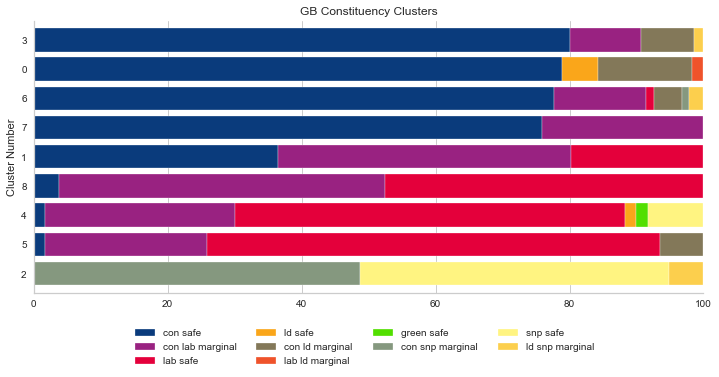

In [144]:
gb_cluster_yg_pivot=gb_cluster_yg_pivot.reindex(party_list)

gb_cluster_bar = (gb_cluster_yg_pivot / gb_cluster_yg_pivot.sum()).T.sort_values(by=['con safe', 'lab safe'], 
                                                                                 ascending=True)

gb_cluster_bar.plot.barh(stacked=True,
                          figsize=(12,5),
                          width=0.8,
                          color=party_colors)

plt.xticks(ticks = np.arange(0,1.2,0.2), labels = np.arange(0,120,20))
plt.xlim(0,1);

plt.title('GB Constituency Clusters');
plt.ylabel('Cluster Number')

plt.legend(bbox_to_anchor=(0.85, -0.1),
           ncol=4,
           frameon=False);

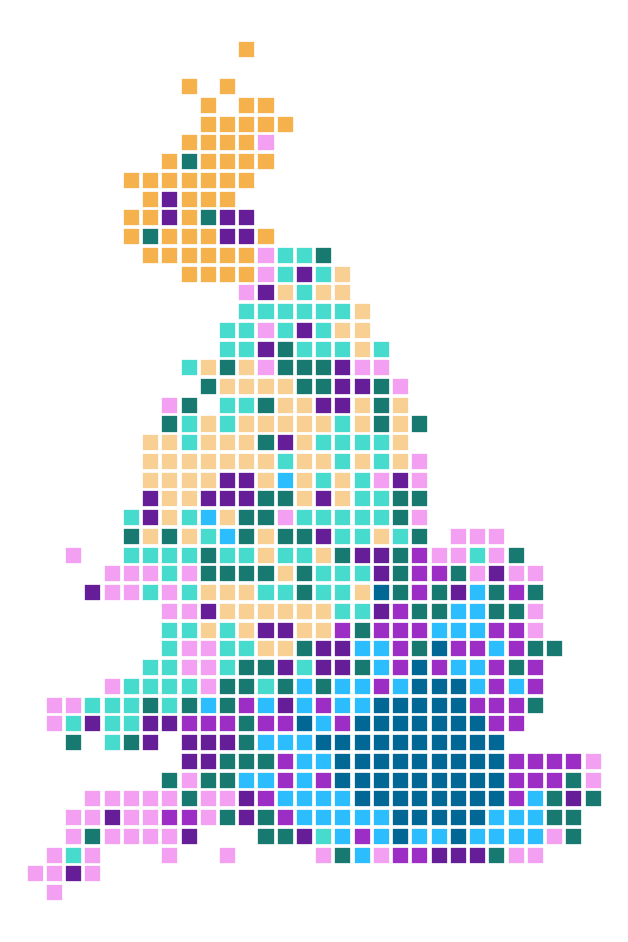

In [145]:
gb_cluster_yg['Colors'] = gb_cluster_yg['Cluster'].map(
    lambda x: color_list[x])

kpi_map('Population',
        colors=gb_cluster_yg[['Colors']],
        data=pd.read_csv('data_with_targets.csv').set_index('ID'),
        exc_color='#ffffff',
        exclude=['Northern Ireland'],
        width=11)

In [146]:
# Finally BIC Score of 9 Clusters and full covariance
# Let us try Calinski 9 clusters
model = GaussianMixture(n_components= 9,covariance_type= "full", random_state = 10)
# fit the model
model.fit(umap_df)
# assign a cluster to each example
yhat = model.predict(umap_df)
# retrieve unique clusters
clusters = unique(yhat)


db_preds_gb = []
#Store the predicted labels
db_preds_gb.append(yhat)


gb_cluster_yg = pd.concat([y19_st_gb,
                           pd.DataFrame(db_preds_gb[0], 
                                        index=y17_st_gb.index,
                                        columns=['Cluster'])],
                           axis=1)

gb_cluster_yg_pivot = pd.pivot_table(data = gb_cluster_yg,
                                     index='seat_types_yg',
                                     columns='Cluster',
                                     aggfunc=len,
                                     fill_value=0)

gb_cluster_yg_pivot

Cluster,0,1,2,3,4,5,6,7,8
seat_types_yg,,,,,,,,,
con lab marginal,2,39,0,8,17,14,13,12,42
con ld marginal,8,0,0,6,0,4,4,0,0
con pc marginal,0,0,0,1,0,0,0,0,0
con safe,48,26,0,54,1,1,75,51,3
con snp marginal,0,0,19,0,0,0,1,0,0
green safe,0,0,0,0,1,0,0,0,0
lab ld marginal,1,0,0,0,0,0,0,0,0
lab safe,0,18,0,0,37,42,1,0,37
lab snp marginal,0,0,10,0,0,0,0,0,0


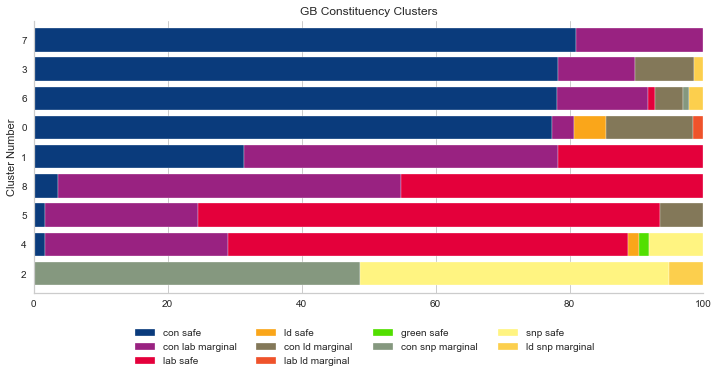

In [147]:
gb_cluster_yg_pivot=gb_cluster_yg_pivot.reindex(party_list)

gb_cluster_bar = (gb_cluster_yg_pivot / gb_cluster_yg_pivot.sum()).T.sort_values(by=['con safe', 'lab safe'], 
                                                                                 ascending=True)

gb_cluster_bar.plot.barh(stacked=True,
                          figsize=(12,5),
                          width=0.8,
                          color=party_colors)

plt.xticks(ticks = np.arange(0,1.2,0.2), labels = np.arange(0,120,20))
plt.xlim(0,1);

plt.title('GB Constituency Clusters');
plt.ylabel('Cluster Number')

plt.legend(bbox_to_anchor=(0.85, -0.1),
           ncol=4,
           frameon=False);

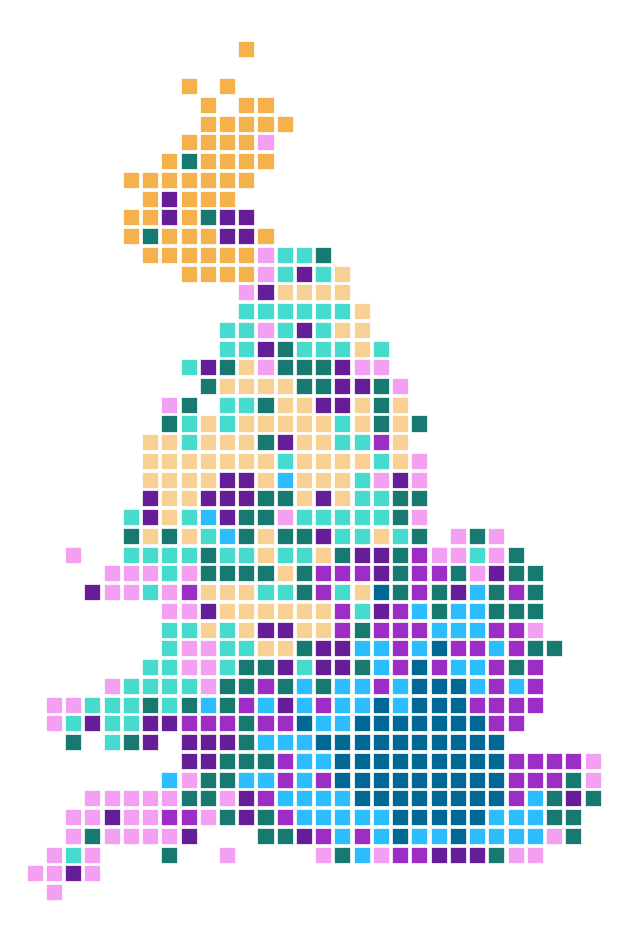

In [148]:
gb_cluster_yg['Colors'] = gb_cluster_yg['Cluster'].map(
    lambda x: color_list[x])

kpi_map('Population',
        colors=gb_cluster_yg[['Colors']],
        data=pd.read_csv('data_with_targets.csv').set_index('ID'),
        exc_color='#ffffff',
        exclude=['Northern Ireland'],
        width=11)

#### PCA

In [149]:
# BIC for GMM
### Using Bayesian information criterion score for Gaussian Mixture Modelling 
from sklearn.mixture import GaussianMixture
n_components = range(1, 30)
covariance_type = ['spherical', 'tied', 'diag', 'full']
score=[]
for cov in covariance_type:
    for n_comp in n_components:
        gmm=GaussianMixture(n_components=n_comp,covariance_type=cov, random_state = 10)
        gmm.fit(PCA_df_gb)
        score.append((cov,n_comp,gmm.bic(PCA_df_gb)))
score_1 = pd.DataFrame(score)
score_1.columns = ['Covariance_Type', 'N_Components','BIC_Score']
score_2 = score_1[score_1.BIC_Score == score_1.BIC_Score.min()]

score_2.head(n=2)

,Covariance_Type,N_Components,BIC_Score
89,full,3,40260.034891


In [150]:
# Calinski Harabasz Score for GMM


n_components = range(2, 30)
covariance_type = ['spherical', 'tied', 'diag', 'full']
score=[]
for cov in covariance_type:
    for n_comp in n_components:
        gmm=GaussianMixture(n_components=n_comp,covariance_type=cov, random_state = 10)
        model = gmm.fit(PCA_df_gb)
        model_2 = model.predict(PCA_df_gb)
        score_c = calinski_harabasz_score(PCA_df_gb, model_2)
        score.append((cov,n_comp,score_c))
score_1 = pd.DataFrame(score)
score_1.columns = ['Covariance_Type', 'N_Components','Calinski_Harabasz_Score']
score_2 = score_1[score_1.Calinski_Harabasz_Score == score_1.Calinski_Harabasz_Score.max()]
score_2.head(n=5)

,Covariance_Type,N_Components,Calinski_Harabasz_Score
28,tied,2,179.134324


In [151]:
# Silhouette Score for GMM


n_components = range(2, 30)
covariance_type = ['spherical', 'tied', 'diag', 'full']
score=[]
for cov in covariance_type:
    for n_comp in n_components:
        gmm=GaussianMixture(n_components=n_comp,covariance_type=cov, random_state = 10)
        model = gmm.fit(PCA_df_gb)
        model_2 = model.predict(PCA_df_gb)
        score_c = silhouette_score(PCA_df_gb, model_2)
        score.append((cov,n_comp,score_c))
score_1 = pd.DataFrame(score)
score_1.columns = ['Covariance_Type', 'N_Components','Silhouette_Score']
score_2 = score_1[score_1.Silhouette_Score == score_1.Silhouette_Score.max()]
score_2.head(n=5)

,Covariance_Type,N_Components,Silhouette_Score
28,tied,2,0.429521


In [152]:
# Davies Bouldin Score for GMM


n_components = range(2, 30)
covariance_type = ['spherical', 'tied', 'diag', 'full']
score=[]
for cov in covariance_type:
    for n_comp in n_components:
        gmm=GaussianMixture(n_components=n_comp,covariance_type=cov, random_state = 10)
        model = gmm.fit(PCA_df_gb)
        model_2 = model.predict(PCA_df_gb)
        score_c = davies_bouldin_score(PCA_df_gb, model_2)
        score.append((cov,n_comp,score_c))
score_1 = pd.DataFrame(score)
score_1.columns = ['Covariance_Type', 'N_Components','Davies_Bouldin']
score_2 = score_1[score_1.Davies_Bouldin == score_1.Davies_Bouldin.min()]
score_2.head(n=5)

,Covariance_Type,N_Components,Davies_Bouldin
28,tied,2,1.232706


#### Clustering Analysis

In [153]:
# The majority for three metrics out of 4 is tied covariance and 2 components but the component number is too low hence we will
# go with the BIC score of full covariance and 3 components

In [154]:
# Finally BIC Score of 3 Clusters and full covariance
model = GaussianMixture(n_components= 2,covariance_type= "tied", random_state = 12)
# fit the model
model.fit(PCA_df_gb)
# assign a cluster to each example
yhat = model.predict(PCA_df_gb)
# retrieve unique clusters
clusters = unique(yhat)


db_preds_gb = []
#Store the predicted labels
db_preds_gb.append(yhat)


gb_cluster_yg = pd.concat([y19_st_gb,
                           pd.DataFrame(db_preds_gb[0], 
                                        index=y17_st_gb.index,
                                        columns=['Cluster'])],
                           axis=1)

gb_cluster_yg_pivot = pd.pivot_table(data = gb_cluster_yg,
                                     index='seat_types_yg',
                                     columns='Cluster',
                                     aggfunc=len,
                                     fill_value=0)

gb_cluster_yg_pivot

Cluster,0,1
seat_types_yg,,
con lab marginal,13,134
con ld marginal,3,19
con pc marginal,0,1
con safe,1,258
con snp marginal,0,20
green safe,0,1
lab ld marginal,0,1
lab safe,48,87
lab snp marginal,0,10


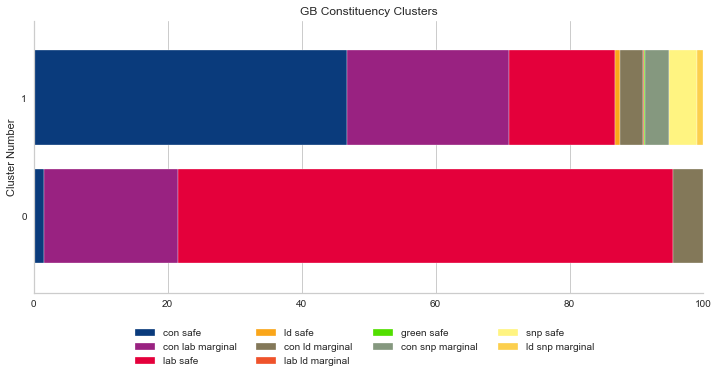

In [155]:
gb_cluster_yg_pivot=gb_cluster_yg_pivot.reindex(party_list)

gb_cluster_bar = (gb_cluster_yg_pivot / gb_cluster_yg_pivot.sum()).T.sort_values(by=['con safe', 'lab safe'], 
                                                                                 ascending=True)

gb_cluster_bar.plot.barh(stacked=True,
                          figsize=(12,5),
                          width=0.8,
                          color=party_colors)

plt.xticks(ticks = np.arange(0,1.2,0.2), labels = np.arange(0,120,20))
plt.xlim(0,1);

plt.title('GB Constituency Clusters');
plt.ylabel('Cluster Number')

plt.legend(bbox_to_anchor=(0.85, -0.1),
           ncol=4,
           frameon=False);

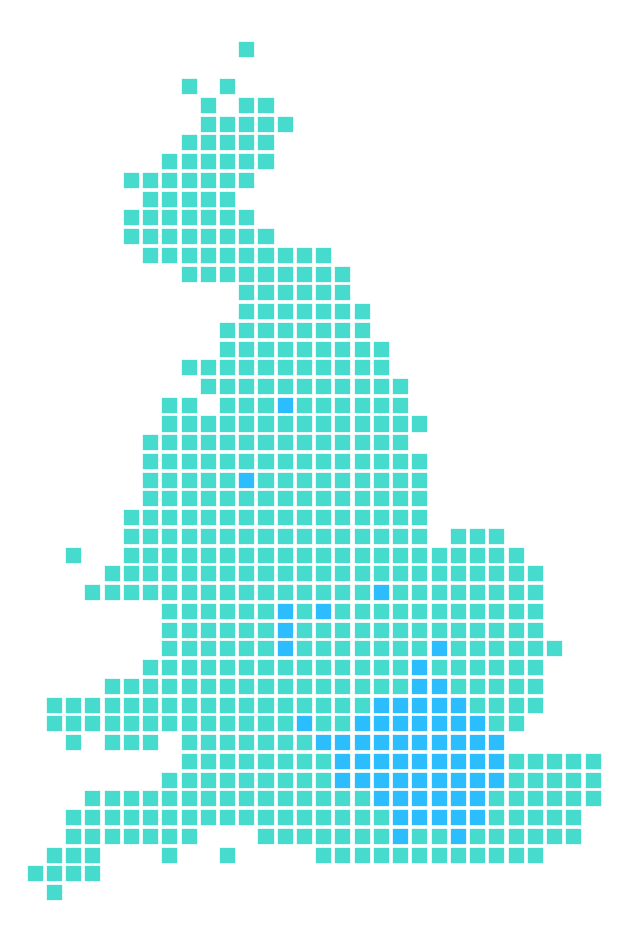

In [156]:
gb_cluster_yg['Colors'] = gb_cluster_yg['Cluster'].map(
    lambda x: color_list[x])

kpi_map('Population',
        colors=gb_cluster_yg[['Colors']],
        data=pd.read_csv('data_with_targets.csv').set_index('ID'),
        exc_color='#ffffff',
        exclude=['Northern Ireland'],
        width=11)

## Final Insights & Discussion

In [157]:
# Define functions for output maps and table

## Conclusion